Import libraries

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt
import collections
import optuna
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Load Dataset

In [2]:
import tensorflow_datasets as tfds

def load_imdb_data():
    imdb, _ = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
    return imdb['train'], imdb['test']

train_data, test_data = load_imdb_data()

Split into Test, Validation and Train

In [3]:
def split_train_validation(train_data, validation_split=0.2):
    train_list = list(train_data.skip(int(validation_split * len(list(train_data)))).as_numpy_iterator())
    validation_list = list(train_data.take(int(validation_split * len(list(train_data)))).as_numpy_iterator())

    train_labels = [label for _, label in train_list]
    validation_labels = [label for _, label in validation_list]

    print(f"Training set size: {len(train_list)}")
    print(f"Validation set size: {len(validation_list)}")

    return train_list, validation_list, train_labels, validation_labels

train_list, validation_list, train_labels, validation_labels = split_train_validation(train_data)

test_list = list(test_data.as_numpy_iterator())
test_labels = [label for _, label in test_list]

print(f"Test set size: {len(test_list)}")

Training set size: 20000
Validation set size: 5000
Test set size: 25000


EDA

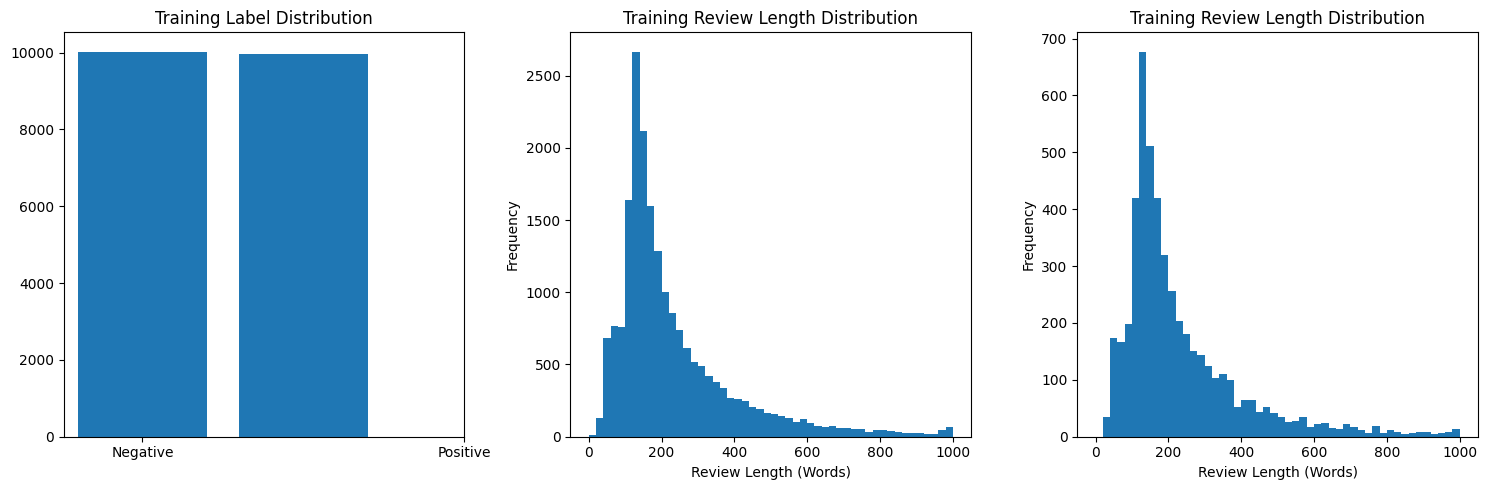

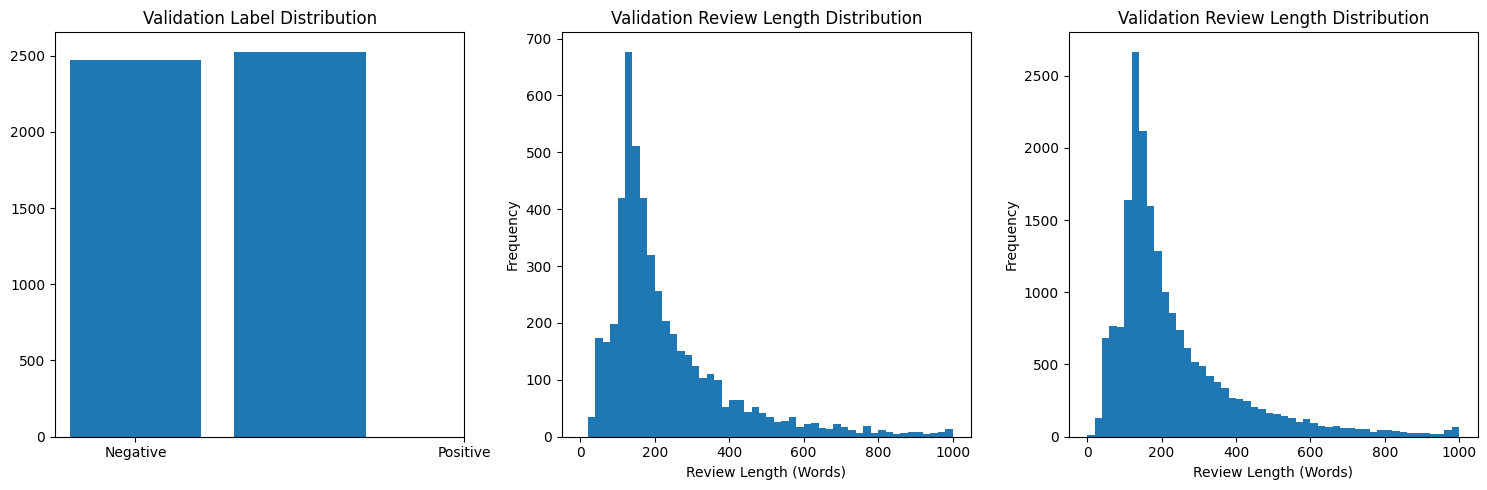

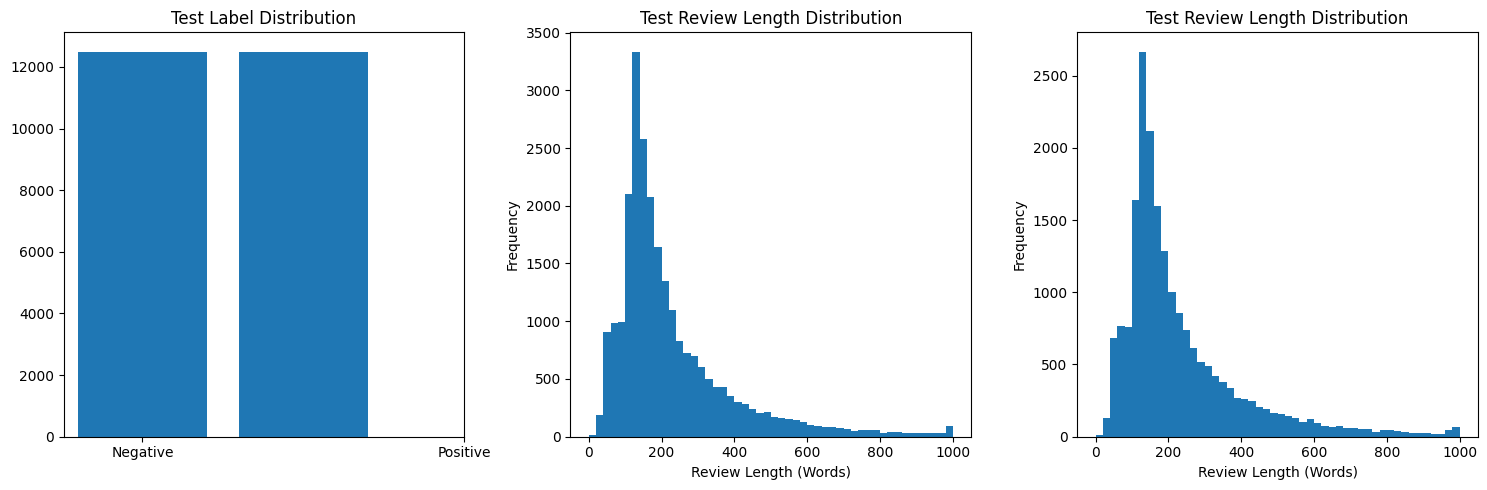


Average Training Review Length: 233.90 words
Average Validation Review Length: 233.35 words
Average Test Review Length: 228.53 words


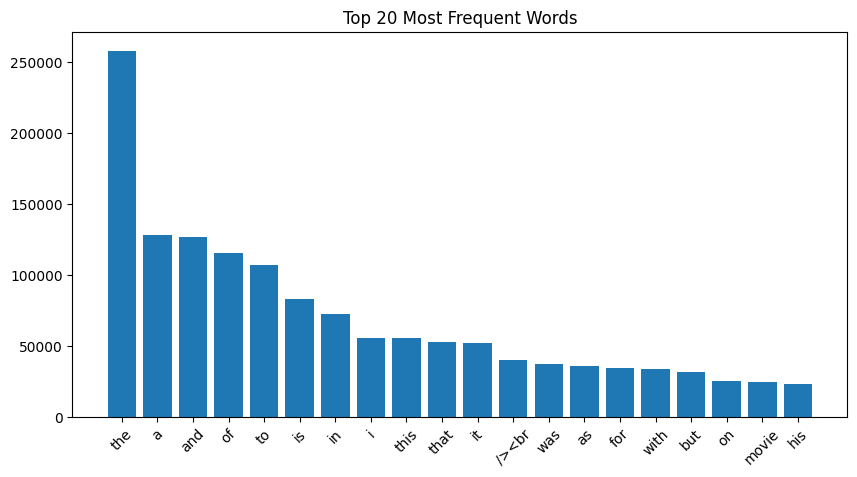

Average Word Length: 4.67
Unique Word Count: 219700
Review Length Standard Deviation: 173.50
Html tag count: 81191
Special character count: 1066364


In [6]:
def plot_distributions(labels_list, lengths_list, title_prefix):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(labels_list[0], bins=2, rwidth=0.8, align='left')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.title(f'{title_prefix} Label Distribution')

    plt.subplot(1, 3, 2)
    plt.hist(lengths_list[0], bins=50, range=(0, 1000))
    plt.title(f'{title_prefix} Review Length Distribution')
    plt.xlabel('Review Length (Words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(lengths_list[1], bins=50, range=(0, 1000))
    plt.title(f'{title_prefix} Review Length Distribution')
    plt.xlabel('Review Length (Words)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def analyze_words(text_list):
    all_words = []
    for text, _ in text_list:
        all_words.extend(text.decode('utf-8').lower().split())

    word_counts = collections.Counter(all_words)
    top_words = word_counts.most_common(20)

    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title('Top 20 Most Frequent Words')
    plt.show()

    word_lengths = [len(word) for word in all_words]
    print(f"Average Word Length: {np.mean(word_lengths):.2f}")
    print(f"Unique Word Count: {len(set(all_words))}")

def analyze_special_chars(text_list):
    html_tag_regex = re.compile(r'<[^>]+>')
    special_char_regex = re.compile(r'[^a-zA-Z0-9\s]')

    html_tag_count = 0
    special_char_count = 0

    for text, _ in text_list:
        decoded_text = text.decode('utf-8')
        html_tag_count += len(html_tag_regex.findall(decoded_text))
        special_char_count += len(special_char_regex.findall(decoded_text))

    print(f"Html tag count: {html_tag_count}")
    print(f"Special character count: {special_char_count}")

# Calculate lengths
train_lengths = [len(text.decode('utf-8').split()) for text, _ in train_list]
validation_lengths = [len(text.decode('utf-8').split()) for text, _ in validation_list]
test_lengths = [len(text.decode('utf-8').split()) for text, _ in test_list]

# Plot Distributions
plot_distributions([train_labels, validation_labels, test_labels], [train_lengths, validation_lengths, test_lengths], 'Training')
plot_distributions([validation_labels, train_labels, test_labels], [validation_lengths, train_lengths, test_lengths], 'Validation')
plot_distributions([test_labels, train_labels, validation_labels], [test_lengths, train_lengths, validation_lengths], 'Test')

# Average Review Length
print(f"\nAverage Training Review Length: {np.mean(train_lengths):.2f} words")
print(f"Average Validation Review Length: {np.mean(validation_lengths):.2f} words")
print(f"Average Test Review Length: {np.mean(test_lengths):.2f} words")

# Word Analysis
analyze_words(train_list)

# Review Length Variability
print(f"Review Length Standard Deviation: {np.std(train_lengths):.2f}")

# Special Character Analysis
analyze_special_chars(train_list)

Text Preprocessing

In [7]:
def remove_html_tags(text):
    """Removes HTML tags from a string."""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def decode_clean_text(data_list):
    """Decodes byte strings and removes HTML tags from text data."""
    sentences = [remove_html_tags(text.decode('utf-8')) for text, _ in data_list]
    return sentences

def tokenize_pad_sequences(train_sentences, validation_sentences, test_sentences, num_words=20000, max_length=200):
    """Tokenizes and pads text sequences."""
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_sentences)

    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
    test_sequences = tokenizer.texts_to_sequences(test_sentences)

    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
    validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post', truncating='post')
    test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

    return train_padded, validation_padded, test_padded

def create_tensors_dataloaders(train_padded, validation_padded, test_padded, train_list, validation_list, test_list, batch_size=64):
    """Converts padded sequences and labels to PyTorch tensors and DataLoaders."""
    train_labels_np = np.array([label for _, label in train_list])
    validation_labels_np = np.array([label for _, label in validation_list])
    test_labels_np = np.array([label for _, label in test_list])

    train_data = torch.tensor(train_padded, dtype=torch.long)
    train_labels_tensor = torch.tensor(train_labels_np, dtype=torch.float32).view(-1, 1)
    validation_data = torch.tensor(validation_padded, dtype=torch.long)
    validation_labels_tensor = torch.tensor(validation_labels_np, dtype=torch.float32).view(-1, 1)
    test_data = torch.tensor(test_padded, dtype=torch.long)
    test_labels_tensor = torch.tensor(test_labels_np, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(train_data, train_labels_tensor)
    validation_dataset = TensorDataset(validation_data, validation_labels_tensor)
    test_dataset = TensorDataset(test_data, test_labels_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, validation_loader, test_loader

def process_text(train_list, validation_list, test_list, num_words=20000, max_length=200, batch_size=64):
    """Executes the text processing pipeline."""
    train_sentences = decode_clean_text(train_list)
    validation_sentences = decode_clean_text(validation_list)
    test_sentences = decode_clean_text(test_list)

    train_padded, validation_padded, test_padded = tokenize_pad_sequences(train_sentences, validation_sentences, test_sentences, num_words, max_length)

    train_loader, validation_loader, test_loader = create_tensors_dataloaders(train_padded, validation_padded, test_padded, train_list, validation_list, test_list, batch_size)

    return train_loader, validation_loader, test_loader

train_loader, validation_loader, test_loader = process_text(train_list, validation_list, test_list)

Model definition

In [38]:
def create_rnn_model(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate, device):
    """Creates and returns an RNN model with normalization."""
    class RNN(nn.Module):
        def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate):
            super(RNN, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.embedding_norm = nn.LayerNorm(embedding_dim) 
            self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
            self.gru_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

            self.fc_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim) 

            self.sigmoid = nn.Sigmoid()

        def forward(self, text):
            embedded = self.embedding(text)
            embedded_norm = self.embedding_norm(embedded) # Normalize embedded.
            output, hidden = self.gru(embedded_norm)
            if self.gru.bidirectional:
                hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
            else:
                hidden = hidden[-1, :, :]
            hidden_norm = self.gru_norm(hidden) # Normalize hidden.
            hidden_drop = self.dropout(hidden_norm)
            hidden_fc_norm = self.fc_norm(hidden_drop) # Normalize linear input.
            out = self.fc(hidden_fc_norm)
            return self.sigmoid(out)
    return RNN(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate).to(device)

# Model Parameters
vocab_size = 20000
embedding_dim = 16
hidden_dim = 32
output_dim = 1
num_layers = 5
bidirectional = True
dropout_rate = 0.4
weight_decay = 0.0001

# Create the model
model = create_rnn_model(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate, device)

Training The model

Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6965          0.5260          0.6818          0.5700         
2          0.6682          0.5943          0.6418          0.6378         
3          0.5829          0.6952          0.5270          0.7514         
4          0.4507          0.7935          0.4483          0.8014         
5          0.3730          0.8394          0.4206          0.8296         
6          0.3182          0.8702          0.4541          0.8296         
7          0.2786          0.8908          0.4026          0.8424         
8          0.2466          0.9068          0.4414          0.8460         
9          0.2166          0.9206          0.4896          0.8386         
10         0.1884          0.9339          0.4985          0.8390         


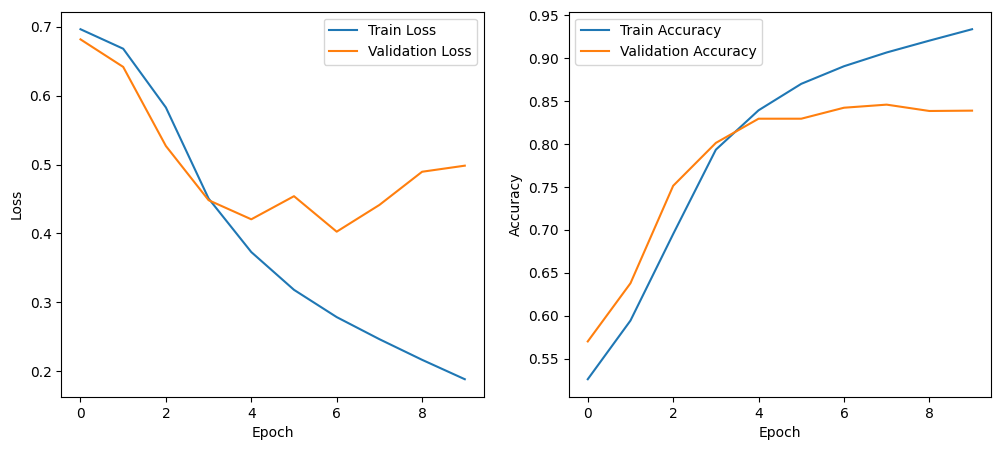

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_validate(model, train_loader, validation_loader, epochs=10, patience=5):
    """Trains and validates the model with early stopping."""
    torch.cuda.empty_cache()

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    counter = 0

    print("{:<10} {:<15} {:<15} {:<15} {:<15}".format("Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc"))
    print("-" * 65)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_text, batch_labels in train_loader:
            batch_text = batch_text.to(model.embedding.weight.device)
            batch_labels = batch_labels.to(model.embedding.weight.device)
            optimizer.zero_grad()
            predictions = model(batch_text)
            loss = criterion(predictions, batch_labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predicted_train = torch.round(predictions)
            correct_train += (predicted_train == batch_labels).sum().item()
            total_train += batch_labels.size(0)

        train_accuracy = correct_train / total_train
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_text, batch_labels in validation_loader:
                batch_text = batch_text.to(model.embedding.weight.device)
                batch_labels = batch_labels.to(model.embedding.weight.device)
                predictions = model(batch_text)
                loss = criterion(predictions, batch_labels)
                total_val_loss += loss.item()
                predicted_val = torch.round(predictions)
                correct_val += (predicted_val == batch_labels).sum().item()
                total_val += batch_labels.size(0)

        val_accuracy = correct_val / total_val
        avg_val_loss = total_val_loss / len(validation_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print("{:<10} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f}".format(epoch + 1, avg_train_loss, train_accuracy, avg_val_loss, val_accuracy))

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plots training and validation losses and accuracies."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Train and validate the model
train_losses, val_losses, train_accuracies, val_accuracies = train_validate(model, train_loader, validation_loader)

# Plot the results
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

Test execution

In [40]:
criterion = nn.BCELoss()

model.eval()
test_loss = 0
correct_test = 0
with torch.no_grad():
    for batch_text, batch_labels in test_loader:
        batch_text = batch_text.to(device)
        batch_labels = batch_labels.to(device)
        predictions = model(batch_text)
        test_loss += criterion(predictions, batch_labels).item()
        predicted_test = torch.round(predictions)
        correct_test += (predicted_test == batch_labels).sum().item()

test_accuracy = correct_test / len(test_loader.dataset)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.5388, Test Accuracy: 0.8246


GridSearchCV

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Convert train_list and test_list to numpy arrays.
def convert_to_numpy(data_list):
    """Converts a list of (text, label) tuples to NumPy arrays."""
    texts = [text.decode('utf-8') for text, _ in data_list]
    labels = np.array([label for _, label in data_list])
    return texts, labels

train_texts, train_labels = convert_to_numpy(train_list)
test_texts, test_labels = convert_to_numpy(test_list)

# Tokenize and pad the sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize_pad(texts, max_length=200, num_words=20000):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    return padded_sequences

train_data = tokenize_pad(train_texts)
test_data = tokenize_pad(test_texts)

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PyTorchGRUClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate, weight_decay, epochs=10, patience=3):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout_rate = dropout_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.patience = patience
        self.model = None

    def fit(self, X, y):
        print("Model Parameters:")
        print(f"  Vocab Size: {self.vocab_size}")
        print(f"  Embedding Dim: {self.embedding_dim}")
        print(f"  Hidden Dim: {self.hidden_dim}")
        print(f"  Output Dim: {self.output_dim}")
        print(f"  Num Layers: {self.num_layers}")
        print(f"  Bidirectional: {self.bidirectional}")
        print(f"  Dropout Rate: {self.dropout_rate}")
        print(f"  Weight Decay: {self.weight_decay}")
        print(f"  Epochs: {self.epochs}")
        print("="*50)
        train_dataset = TensorDataset(torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.float32).view(-1, 1))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        val_size = int(0.2 * len(train_dataset))
        train_size = len(train_dataset) - val_size
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        validation_loader = DataLoader(val_subset, batch_size=32)

        class RNN(nn.Module):
            def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout_rate):
                super(RNN, self).__init__()
                self.embedding = nn.Embedding(vocab_size, embedding_dim)
                self.embedding_norm = nn.LayerNorm(embedding_dim) 
                self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
                self.gru_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim) 
                self.dropout = nn.Dropout(dropout_rate)
                self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
                self.fc_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim) 
                self.sigmoid = nn.Sigmoid()

            def forward(self, text):
                embedded = self.embedding(text)
                embedded_norm = self.embedding_norm(embedded) 
                output, hidden = self.gru(embedded_norm)
                if bidirectional:
                    hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
                else:
                    hidden = hidden[-1, :, :]
                hidden_norm = self.gru_norm(hidden) 
                hidden_drop = self.dropout(hidden_norm)
                hidden_fc_norm = self.fc_norm(hidden_drop) 
                out = self.fc(hidden_fc_norm)
                return self.sigmoid(out)

        self.model = RNN(self.vocab_size, self.embedding_dim, self.hidden_dim, self.output_dim, self.num_layers, self.bidirectional, self.dropout_rate).to(device)
        train_validate(self.model, train_loader, validation_loader, self.epochs, self.patience)
        return self

    def predict(self, X):
        test_dataset = TensorDataset(torch.tensor(X, dtype=torch.long))
        test_loader = DataLoader(test_dataset, batch_size=32)

        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch_text, in test_loader:
                batch_text = batch_text.to(device)
                preds = self.model(batch_text)
                predictions.extend(torch.round(preds).cpu().numpy())
        return np.array(predictions).flatten()

pipeline = Pipeline([
    ('gru', PyTorchGRUClassifier(vocab_size=20000, output_dim=1, embedding_dim=8, hidden_dim=16, num_layers=3, bidirectional=True, dropout_rate=0.5, weight_decay=1e-5, epochs=10, patience=3))
])

param_grid = {
    'gru__embedding_dim': [16, 32],
    'gru__hidden_dim': [16, 32],
    'gru__num_layers': [2, 3],
    'gru__bidirectional': [True, False],
    'gru__dropout_rate': [0.4, 0.5],
    'gru__weight_decay': [1e-3, 1e-4],
    'gru__epochs': [10],
    'gru__patience': [3]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=1, verbose=1)
grid_search.fit(train_data, train_labels)

if grid_search.best_estimator_:
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    # Evaluate on test data
    predictions = grid_search.predict(test_data)
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Test Accuracy: {accuracy}")
else:
    print("GridSearchCV did not complete successfully.")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6996          0.5026          0.6895          0.5484         
2          0.6900          0.5330          0.6721          0.5840         
3          0.6404          0.6379          0.5372          0.7412         
4          0.4940          0.7737          0.4124          0.8185         
5          0.4038          0.8299          0.3461          0.8650         
6          0.3385          0.8654          0.2979          0.8905         
7          0.2962          0.8888          0.2483          0.9115         
8          0.2566          0.9097          0.2569          0.9119         
9          0

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6982          0.5141          0.6872          0.5413         
2          0.6887          0.5360          0.6722          0.5833         
3          0.6723          0.5849          0.6842          0.5563         
4          0.6173          0.6653          0.5246          0.7502         
5          0.5159          0.7616          0.4180          0.8237         
6          0.4237          0.8212          0.3454          0.8597         
7          0.3472          0.8619          0.2793          0.8980         
8          0.2946          0.8887          0.2579          0.9089         
9          0.2528          0.9088          0.2064          0.9374         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7017          0.5057          0.6940          0.5083         
2          0.6908          0.5319          0.6785          0.5608         
3          0.6700          0.5817          0.6256          0.6500         
4          0.5906          0.6916          0.5631          0.7236         
5          0.4583          0.7959          0.3517          0.8496         
6          0.3803          0.8388          0.2817          0.8826         
7          0.3153          0.8737          0.2576          0.8965         
8          0.2739          0.8970          0.1925          0.9310         
9          0.2301          0.9176          0.2169          0.9227         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7019          0.5101          0.6887          0.5405         
2          0.6906          0.5318          0.6777          0.5743         
3          0.6678          0.5921          0.6290          0.6647         
4          0.5828          0.6989          0.5490          0.7266         
5          0.4540          0.8028          0.3493          0.8556         
6          0.3699          0.8481          0.3114          0.8743         
7          0.3094          0.8815          0.2243          0.9201         
8          0.2629          0.9047          0.2592          0.9021         
9          0.2255          0.9209          0.1516          0.9535         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6998          0.5174          0.6863          0.5364         
2          0.6860          0.5453          0.6728          0.5780         
3          0.6535          0.6197          0.6068          0.6759         
4          0.5518          0.7223          0.4283          0.8053         
5          0.4196          0.8169          0.3326          0.8623         
6          0.3445          0.8574          0.2597          0.9017         
7          0.2876          0.8912          0.2220          0.9197         
8          0.2432          0.9113          0.1870          0.9385         
9          0.2051          0.9299          0.1491          0.9569         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7012          0.5091          0.6890          0.5420         
2          0.6894          0.5337          0.6756          0.5653         
3          0.6659          0.5979          0.6495          0.6009         
4          0.5889          0.6960          0.4798          0.7798         
5          0.4832          0.7802          0.4447          0.8113         
6          0.3966          0.8325          0.3309          0.8668         
7          0.3310          0.8676          0.2739          0.8927         
8          0.2826          0.8930          0.2272          0.9197         
9          0.2471          0.9108          0.2003          0.9302         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7006          0.5054          0.6821          0.5660         
2          0.6747          0.5736          0.6190          0.6632         
3          0.5739          0.7038          0.4495          0.7978         
4          0.4360          0.8060          0.3816          0.8331         
5          0.3542          0.8540          0.3017          0.8788         
6          0.3036          0.8794          0.2779          0.8935         
7          0.2616          0.9013          0.2067          0.9280         
8          0.2241          0.9192          0.1766          0.9430         
9          0.1841          0.9397          0.1383          0.9595         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7026          0.5034          0.6871          0.5450         
2          0.6875          0.5363          0.6641          0.6002         
3          0.6345          0.6457          0.6206          0.6740         
4          0.5132          0.7583          0.4077          0.8215         
5          0.4120          0.8231          0.3203          0.8665         
6          0.3422          0.8608          0.2638          0.8972         
7          0.2870          0.8915          0.2122          0.9276         
8          0.2437          0.9123          0.1698          0.9434         
9          0.2140          0.9262          0.1506          0.9501         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6978          0.5225          0.6802          0.5660         
2          0.6707          0.5893          0.6172          0.6755         
3          0.6021          0.6904          0.5196          0.7431         
4          0.5194          0.7575          0.4374          0.8166         
5          0.4354          0.8119          0.3488          0.8627         
6          0.3683          0.8504          0.2920          0.8905         
7          0.3198          0.8766          0.2857          0.8920         
8          0.2813          0.8963          0.2256          0.9231         
9          0.2441          0.9128          0.1809          0.9426         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7019          0.5057          0.6855          0.5416         
2          0.6763          0.5708          0.6282          0.6459         
3          0.5892          0.6913          0.4951          0.7629         
4          0.4586          0.7908          0.3576          0.8458         
5          0.3767          0.8440          0.3212          0.8728         
6          0.3178          0.8750          0.2468          0.9047         
7          0.2802          0.8936          0.2115          0.9239         
8          0.2385          0.9152          0.1897          0.9359         
9          0.2126          0.9260          0.1623          0.9475         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7007          0.5028          0.6910          0.5030         
2          0.6861          0.5408          0.6646          0.5926         
3          0.6316          0.6459          0.5365          0.7333         
4          0.4961          0.7715          0.3770          0.8447         
5          0.3869          0.8373          0.3101          0.8773         
6          0.3238          0.8735          0.2536          0.9047         
7          0.2787          0.8936          0.2062          0.9287         
8          0.2384          0.9131          0.1817          0.9464         
9          0.2032          0.9322          0.1632          0.9512         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7007          0.5142          0.6890          0.5353         
2          0.6829          0.5555          0.6534          0.6114         
3          0.6379          0.6444          0.5646          0.7134         
4          0.5592          0.7255          0.4971          0.7734         
5          0.4660          0.7932          0.3783          0.8432         
6          0.3867          0.8404          0.3226          0.8713         
7          0.3316          0.8703          0.2541          0.9115         
8          0.2866          0.8928          0.2757          0.9051         
9          0.2508          0.9111          0.1908          0.9430         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7011          0.5132          0.6853          0.5465         
2          0.6866          0.5445          0.6535          0.6283         
3          0.6433          0.6278          0.5593          0.7104         
4          0.5218          0.7433          0.4129          0.8166         
5          0.4078          0.8201          0.3064          0.8725         
6          0.3330          0.8621          0.2871          0.8878         
7          0.2844          0.8855          0.2418          0.8980         
8          0.2338          0.9131          0.1547          0.9479         
9          0.2000          0.9296          0.1789          0.9287         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7019          0.5093          0.6839          0.5540         
2          0.6763          0.5726          0.6475          0.6358         
3          0.6623          0.6050          0.6405          0.6279         
4          0.5700          0.7052          0.4683          0.7907         
5          0.4354          0.8023          0.4015          0.8331         
6          0.3564          0.8506          0.3211          0.8590         
7          0.2992          0.8810          0.2450          0.9070         
8          0.2530          0.9010          0.2201          0.9190         
9          0.2219          0.9165          0.2027          0.9284         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7007          0.5106          0.6801          0.5731         
2          0.6797          0.5680          0.6735          0.6009         
3          0.6236          0.6545          0.5894          0.6905         
4          0.5354          0.7381          0.4408          0.8057         
5          0.4275          0.8107          0.3528          0.8515         
6          0.3541          0.8574          0.2850          0.8931         
7          0.2930          0.8874          0.2383          0.9137         
8          0.2498          0.9077          0.1963          0.9389         
9          0.2098          0.9285          0.1634          0.9512         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7006          0.5157          0.6883          0.5386         
2          0.6788          0.5690          0.6479          0.6257         
3          0.5963          0.6860          0.5077          0.7558         
4          0.4689          0.7848          0.4047          0.8301         
5          0.3820          0.8392          0.3174          0.8773         
6          0.3181          0.8711          0.2554          0.9029         
7          0.2719          0.8978          0.2952          0.8953         
8          0.2323          0.9172          0.1894          0.9370         
9          0.1968          0.9311          0.1513          0.9569         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7013          0.5062          0.6869          0.5476         
2          0.6861          0.5473          0.6497          0.6362         
3          0.6376          0.6404          0.5492          0.7326         
4          0.5675          0.7094          0.4356          0.8027         
5          0.4361          0.8039          0.3305          0.8646         
6          0.3573          0.8531          0.2885          0.8878         
7          0.3031          0.8791          0.2226          0.9171         
8          0.2561          0.9036          0.2586          0.9002         
9          0.2187          0.9210          0.1516          0.9479         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6998          0.5048          0.6842          0.5525         
2          0.6813          0.5621          0.6480          0.6249         
3          0.6089          0.6691          0.4949          0.7633         
4          0.4717          0.7828          0.3723          0.8436         
5          0.3796          0.8394          0.3049          0.8811         
6          0.3106          0.8745          0.2612          0.9047         
7          0.2576          0.9019          0.2071          0.9269         
8          0.2169          0.9223          0.2143          0.9317         
9          0.1809          0.9397          0.1429          0.9569         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7020          0.5001          0.6882          0.5424         
2          0.6882          0.5452          0.6697          0.5788         
3          0.6245          0.6581          0.5052          0.7588         
4          0.4915          0.7703          0.3992          0.8263         
5          0.3893          0.8355          0.3407          0.8575         
6          0.3262          0.8672          0.2743          0.8983         
7          0.2807          0.8924          0.3720          0.8496         
8          0.2389          0.9112          0.1883          0.9407         
9          0.1973          0.9304          0.1554          0.9505         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7002          0.5123          0.6943          0.5203         
2          0.6803          0.5708          0.6396          0.6328         
3          0.5773          0.7034          0.4468          0.7903         
4          0.4490          0.7952          0.3431          0.8575         
5          0.3683          0.8438          0.3314          0.8560         
6          0.3084          0.8748          0.2397          0.9179         
7          0.2554          0.9009          0.2088          0.9284         
8          0.2185          0.9206          0.1878          0.9434         
9          0.1835          0.9381          0.1560          0.9591         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6989          0.5182          0.6822          0.5634         
2          0.6680          0.5911          0.6576          0.6313         
3          0.5555          0.7245          0.4327          0.8012         
4          0.4232          0.8167          0.3949          0.8278         
5          0.3543          0.8550          0.3075          0.8863         
6          0.2975          0.8851          0.2504          0.9115         
7          0.2482          0.9081          0.2817          0.8935         
8          0.2140          0.9228          0.1800          0.9430         
9          0.1768          0.9417          0.1414          0.9580         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7008          0.5149          0.6800          0.5679         
2          0.6638          0.5960          0.5867          0.6988         
3          0.5397          0.7355          0.4715          0.7952         
4          0.4208          0.8156          0.3304          0.8680         
5          0.3448          0.8557          0.2817          0.8916         
6          0.2945          0.8832          0.2997          0.8800         
7          0.2470          0.9074          0.1773          0.9400         
8          0.2125          0.9247          0.1633          0.9441         
9          0.1821          0.9383          0.1667          0.9426         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7004          0.5086          0.6799          0.5660         
2          0.6660          0.5979          0.6015          0.6797         
3          0.5665          0.7201          0.4727          0.7881         
4          0.4415          0.8008          0.3581          0.8473         
5          0.3631          0.8478          0.3332          0.8725         
6          0.3091          0.8769          0.3005          0.8920         
7          0.2694          0.8993          0.2190          0.9209         
8          0.2236          0.9216          0.1641          0.9494         
9          0.1916          0.9339          0.1343          0.9591         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


1          0.6965          0.5315          0.6875          0.5544         
2          0.6680          0.5908          0.6112          0.6647         
3          0.5645          0.7170          0.4404          0.8038         
4          0.4410          0.8031          0.4381          0.7971         
5          0.3678          0.8499          0.3144          0.8713         
6          0.3154          0.8765          0.2501          0.8957         
7          0.2682          0.8982          0.2437          0.8987         
8          0.2300          0.9172          0.1649          0.9479         
9          0.1987          0.9330          0.1346          0.9621         
10         0.1652          0.9464          0.1111          0.9662         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6964          0.5306          0.6601          0.6005         
2          0.6949          0.5226          0.6862          0.5413         
3          0.6447          0.6208          0.5308          0.7303         
4          0.4887          0.7675          0.3754          0.8380         
5          0.3840          0.8372          0.3134          0.8758         
6          0.3678          0.8432          0.2607          0.9070         
7          0.2834          0.8915          0.2795          0.8961         
8          0.2408          0.9120          0.1865          0.9396         
9          0.2076          0.9279          0.1539          0.9554         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6975          0.5255          0.6812          0.5634         
2          0.6614          0.6044          0.6856          0.5308         
3          0.5978          0.6697          0.4859          0.7704         
4          0.4404          0.8018          0.3591          0.8500         
5          0.3572          0.8513          0.2759          0.8878         
6          0.2972          0.8804          0.2368          0.9092         
7          0.2476          0.9044          0.1990          0.9280         
8          0.2080          0.9249          0.1794          0.9284         
9          0.1602          0.9449          0.1170          0.9632         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7027          0.5039          0.6853          0.5424         
2          0.6793          0.5729          0.6853          0.5199         
3          0.6380          0.6297          0.5761          0.7224         
4          0.5382          0.7405          0.4966          0.7768         
5          0.4404          0.8058          0.3730          0.8496         
6          0.3712          0.8421          0.3147          0.8800         
7          0.3160          0.8721          0.3086          0.8785         
8          0.2631          0.8975          0.2034          0.9280         
9          0.2193          0.9191          0.1722          0.9389         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7030          0.5135          0.6858          0.5409         
2          0.6632          0.5945          0.5748          0.7153         
3          0.5325          0.7390          0.4161          0.8061         
4          0.4126          0.8184          0.3209          0.8683         
5          0.3403          0.8566          0.2920          0.8803         
6          0.2890          0.8849          0.2174          0.9239         
7          0.2419          0.9076          0.1923          0.9362         
8          0.2092          0.9251          0.1446          0.9565         
9          0.1664          0.9452          0.1156          0.9655         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7051          0.5060          0.6908          0.5420         
2          0.6831          0.5520          0.6607          0.6197         
3          0.6140          0.6646          0.5210          0.7719         
4          0.4527          0.7937          0.3683          0.8458         
5          0.3610          0.8477          0.2813          0.8856         
6          0.2872          0.8870          0.2287          0.9186         
7          0.2393          0.9099          0.2137          0.9216         
8          0.2031          0.9285          0.1517          0.9584         
9          0.1624          0.9461          0.1219          0.9662         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6968          0.5297          0.7024          0.5266         
2          0.6681          0.5931          0.6380          0.6294         
3          0.5879          0.6958          0.4761          0.7776         
4          0.4605          0.7896          0.3636          0.8462         
5          0.3687          0.8428          0.3303          0.8593         
6          0.3051          0.8751          0.2493          0.9122         
7          0.2519          0.9020          0.2033          0.9347         
8          0.2066          0.9244          0.1599          0.9554         
9          0.1687          0.9414          0.1260          0.9651         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7012          0.5131          0.6758          0.5765         
2          0.6626          0.6060          0.5822          0.6969         
3          0.5421          0.7289          0.4164          0.8177         
4          0.4176          0.8142          0.3338          0.8578         
5          0.3442          0.8526          0.3023          0.8668         
6          0.2872          0.8848          0.2085          0.9224         
7          0.2439          0.9091          0.1708          0.9430         
8          0.1999          0.9260          0.1524          0.9494         
9          0.1631          0.9440          0.1472          0.9516         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6999          0.5196          0.6804          0.5773         
2          0.6719          0.5882          0.5988          0.6834         
3          0.5595          0.7149          0.4258          0.8046         
4          0.4128          0.8163          0.3277          0.8687         
5          0.3313          0.8623          0.2729          0.8923         
6          0.2743          0.8943          0.2091          0.9220         
7          0.2309          0.9149          0.1990          0.9280         
8          0.1846          0.9343          0.1914          0.9359         
9          0.1516          0.9500          0.1505          0.9542         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7012          0.5107          0.6981          0.4955         
2          0.6687          0.5868          0.5939          0.6879         
3          0.5278          0.7407          0.4701          0.7989         
4          0.4057          0.8193          0.3119          0.8710         
5          0.3324          0.8628          0.2588          0.8968         
6          0.2759          0.8918          0.2196          0.9190         
7          0.2303          0.9158          0.1711          0.9366         
8          0.1886          0.9314          0.1557          0.9475         
9          0.1529          0.9486          0.0938          0.9741         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7015          0.5128          0.6868          0.5428         
2          0.6715          0.5849          0.6299          0.6459         
3          0.5804          0.7025          0.4682          0.7832         
4          0.4668          0.7883          0.3750          0.8458         
5          0.3767          0.8388          0.3108          0.8803         
6          0.3119          0.8746          0.2664          0.9036         
7          0.2598          0.9011          0.2179          0.9242         
8          0.2199          0.9199          0.1869          0.9392         
9          0.1867          0.9350          0.1775          0.9490         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7004          0.5196          0.6765          0.5720         
2          0.6540          0.6152          0.5602          0.7206         
3          0.5055          0.7600          0.3747          0.8395         
4          0.3959          0.8273          0.3203          0.8800         
5          0.3236          0.8674          0.2614          0.8953         
6          0.2761          0.8915          0.2091          0.9254         
7          0.2277          0.9146          0.1671          0.9411         
8          0.1899          0.9319          0.1233          0.9599         
9          0.1509          0.9473          0.0967          0.9726         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7018          0.5151          0.6787          0.5679         
2          0.6551          0.6109          0.6100          0.6947         
3          0.5393          0.7356          0.4360          0.8008         
4          0.4239          0.8105          0.4800          0.8215         
5          0.3462          0.8538          0.2977          0.8863         
6          0.2856          0.8852          0.2593          0.9025         
7          0.2324          0.9127          0.2067          0.9299         
8          0.1898          0.9293          0.1849          0.9336         
9          0.1535          0.9468          0.1355          0.9629         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6972          0.5150          0.6779          0.5784         
2          0.6696          0.5826          0.6068          0.6800         
3          0.5677          0.7205          0.4531          0.7926         
4          0.4293          0.8140          0.2945          0.8852         
5          0.3449          0.8648          0.2342          0.9167         
6          0.2885          0.8927          0.1857          0.9374         
7          0.2291          0.9198          0.1421          0.9550         
8          0.1835          0.9403          0.1140          0.9681         
9          0.1511          0.9523          0.0888          0.9782         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7012          0.5095          0.6845          0.5518         
2          0.6824          0.5576          0.6605          0.5994         
3          0.6489          0.6302          0.6314          0.6508         
4          0.5751          0.7104          0.6023          0.7052         
5          0.4819          0.7823          0.4092          0.8297         
6          0.3893          0.8363          0.3187          0.8721         
7          0.3150          0.8765          0.2210          0.9224         
8          0.2556          0.9045          0.1909          0.9329         
9          0.2093          0.9267          0.1436          0.9501         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6998          0.5181          0.6846          0.5518         
2          0.6806          0.5616          0.6440          0.6268         
3          0.6190          0.6657          0.5143          0.7524         
4          0.4764          0.7810          0.3247          0.8665         
5          0.3694          0.8484          0.3117          0.8807         
6          0.2814          0.8925          0.1811          0.9329         
7          0.2276          0.9174          0.1434          0.9554         
8          0.1761          0.9411          0.1015          0.9704         
9          0.1435          0.9517          0.0712          0.9827         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7010          0.5122          0.6858          0.5488         
2          0.6865          0.5492          0.6591          0.6020         
3          0.6210          0.6646          0.4917          0.7738         
4          0.4743          0.7871          0.3170          0.8717         
5          0.3740          0.8458          0.2357          0.9149         
6          0.2932          0.8870          0.2021          0.9306         
7          0.2354          0.9112          0.1450          0.9524         
8          0.1933          0.9375          0.1094          0.9636         
9          0.1478          0.9534          0.0828          0.9745         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6981          0.5177          0.6813          0.5645         
2          0.6795          0.5694          0.6335          0.6470         
3          0.6083          0.6743          0.4930          0.7783         
4          0.4875          0.7802          0.4361          0.8117         
5          0.3905          0.8412          0.3463          0.8612         
6          0.3218          0.8755          0.2322          0.9216         
7          0.2685          0.9016          0.2640          0.9025         
8          0.2206          0.9246          0.2087          0.9295         
9          0.1740          0.9441          0.1214          0.9662         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7045          0.5073          0.6846          0.5386         
2          0.6813          0.5622          0.6430          0.6380         
3          0.6165          0.6681          0.5026          0.7644         
4          0.4836          0.7767          0.5461          0.7408         
5          0.3699          0.8478          0.2828          0.8882         
6          0.2870          0.8895          0.1866          0.9359         
7          0.2300          0.9185          0.1503          0.9486         
8          0.1773          0.9391          0.1086          0.9659         
9          0.1454          0.9534          0.1331          0.9527         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6961          0.5228          0.6799          0.5713         
2          0.6730          0.5783          0.6165          0.6568         
3          0.5803          0.7022          0.4608          0.7978         
4          0.4352          0.8080          0.3056          0.8743         
5          0.3385          0.8630          0.2267          0.9111         
6          0.2746          0.8972          0.1776          0.9366         
7          0.2232          0.9188          0.1283          0.9595         
8          0.1792          0.9387          0.0961          0.9700         
9          0.1514          0.9526          0.0866          0.9764         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6991          0.5192          0.6760          0.5791         
2          0.6663          0.5950          0.5902          0.6977         
3          0.6111          0.6722          0.5305          0.7554         
4          0.4769          0.7828          0.3811          0.8410         
5          0.3657          0.8508          0.2996          0.8852         
6          0.2942          0.8874          0.2096          0.9201         
7          0.2353          0.9162          0.1689          0.9445         
8          0.1905          0.9353          0.1193          0.9651         
9          0.1511          0.9529          0.1074          0.9655         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7011          0.5049          0.6814          0.5724         
2          0.6701          0.5913          0.6056          0.6752         
3          0.5715          0.7102          0.4741          0.7806         
4          0.4230          0.8157          0.2949          0.8897         
5          0.3281          0.8712          0.2323          0.9186         
6          0.2680          0.8997          0.2028          0.9299         
7          0.2200          0.9240          0.1324          0.9621         
8          0.1793          0.9402          0.1373          0.9554         
9          0.1431          0.9557          0.1122          0.9715         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6985          0.5142          0.6753          0.5784         
2          0.6463          0.6203          0.5349          0.7397         
3          0.5005          0.7709          0.3839          0.8451         
4          0.3850          0.8392          0.2821          0.8938         
5          0.3078          0.8813          0.2424          0.9111         
6          0.2492          0.9086          0.1954          0.9336         
7          0.2033          0.9296          0.1454          0.9565         
8          0.1706          0.9447          0.1189          0.9696         
9          0.1314          0.9609          0.0968          0.9760         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6986          0.5151          0.6796          0.5754         
2          0.6710          0.5894          0.6202          0.6605         
3          0.6077          0.6785          0.5472          0.7213         
4          0.4884          0.7775          0.3439          0.8556         
5          0.3766          0.8440          0.2703          0.8920         
6          0.3027          0.8831          0.1950          0.9280         
7          0.2470          0.9084          0.1446          0.9479         
8          0.2059          0.9265          0.1319          0.9561         
9          0.1563          0.9502          0.1059          0.9704         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6976          0.5213          0.6717          0.5900         
2          0.6601          0.6111          0.5774          0.7086         
3          0.5563          0.7249          0.3985          0.8263         
4          0.4136          0.8252          0.2889          0.8875         
5          0.3261          0.8689          0.2200          0.9209         
6          0.2677          0.8973          0.1774          0.9400         
7          0.2238          0.9190          0.1379          0.9595         
8          0.1725          0.9421          0.1211          0.9644         
9          0.1431          0.9561          0.0854          0.9775         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7002          0.5183          0.6683          0.6009         
2          0.6570          0.6104          0.6200          0.6650         
3          0.5644          0.7172          0.4331          0.8076         
4          0.4191          0.8109          0.3159          0.8740         
5          0.3145          0.8708          0.2371          0.9104         
6          0.2478          0.9074          0.2121          0.9235         
7          0.1935          0.9323          0.1664          0.9437         
8          0.1533          0.9491          0.1571          0.9467         
9          0.1144          0.9637          0.0830          0.9809         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7012          0.5057          0.6805          0.5641         
2          0.6667          0.5933          0.5855          0.6860         
3          0.5211          0.7514          0.3786          0.8357         
4          0.3803          0.8383          0.2820          0.8901         
5          0.2988          0.8828          0.2002          0.9295         
6          0.2393          0.9130          0.1767          0.9396         
7          0.1838          0.9374          0.1249          0.9591         
8          0.1413          0.9545          0.0837          0.9771         
9          0.1108          0.9661          0.0830          0.9771         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7018          0.5150          0.6768          0.5709         
2          0.6645          0.5938          0.6315          0.6512         
3          0.5184          0.7476          0.3707          0.8376         
4          0.3688          0.8436          0.2862          0.8860         
5          0.2888          0.8859          0.1954          0.9306         
6          0.2276          0.9144          0.1544          0.9471         
7          0.1794          0.9363          0.1772          0.9340         
8          0.1369          0.9553          0.0982          0.9704         
9          0.1038          0.9696          0.0694          0.9831         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7005          0.5200          0.6762          0.5698         
2          0.6428          0.6290          0.5065          0.7641         
3          0.4708          0.7826          0.3390          0.8650         
4          0.3513          0.8533          0.2705          0.8991         
5          0.2826          0.8894          0.2057          0.9299         
6          0.2305          0.9135          0.1648          0.9430         
7          0.1853          0.9356          0.1199          0.9640         
8          0.1422          0.9553          0.0909          0.9749         
9          0.1084          0.9687          0.1732          0.9404         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6962          0.5318          0.6762          0.5713         
2          0.6457          0.6257          0.5605          0.7116         
3          0.4912          0.7689          0.3643          0.8458         
4          0.3646          0.8459          0.2923          0.8822         
5          0.2906          0.8859          0.2125          0.9246         
6          0.2310          0.9164          0.1609          0.9434         
7          0.1835          0.9359          0.1205          0.9636         
8          0.1404          0.9551          0.0936          0.9764         
9          0.1106          0.9664          0.1048          0.9696         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6966          0.5238          0.6659          0.5964         
2          0.6398          0.6362          0.5203          0.7483         
3          0.4743          0.7857          0.3748          0.8515         
4          0.3526          0.8516          0.2755          0.8927         
5          0.2824          0.8893          0.2132          0.9231         
6          0.2256          0.9165          0.1595          0.9464         
7          0.1712          0.9415          0.1716          0.9400         
8          0.1337          0.9568          0.0915          0.9756         
9          0.1043          0.9691          0.0637          0.9846         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6978          0.5270          0.6757          0.5746         
2          0.6397          0.6331          0.5194          0.7543         
3          0.4651          0.7871          0.3697          0.8455         
4          0.3519          0.8545          0.2785          0.8882         
5          0.2783          0.8893          0.2085          0.9276         
6          0.2209          0.9186          0.3192          0.8698         
7          0.1698          0.9424          0.1308          0.9606         
8          0.1341          0.9590          0.1287          0.9587         
9          0.1061          0.9691          0.0840          0.9767         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6969          0.5303          0.6615          0.6129         
2          0.6480          0.6227          0.5832          0.6939         
3          0.4882          0.7667          0.4056          0.8151         
4          0.3644          0.8443          0.2617          0.8923         
5          0.2820          0.8900          0.1945          0.9227         
6          0.2186          0.9193          0.1268          0.9576         
7          0.1720          0.9385          0.0934          0.9711         
8          0.1285          0.9580          0.0710          0.9771         
9          0.0956          0.9725          0.0502          0.9865         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6978          0.5217          0.6720          0.5788         
2          0.6349          0.6353          0.5132          0.7464         
3          0.4590          0.7893          0.2938          0.8848         
4          0.3355          0.8628          0.3373          0.8665         
5          0.2686          0.8973          0.1586          0.9404         
6          0.2104          0.9228          0.1134          0.9655         
7          0.1622          0.9442          0.0927          0.9737         
8          0.1263          0.9584          0.0627          0.9850         
9          0.0951          0.9720          0.0701          0.9801         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6988          0.5341          0.6615          0.5968         
2          0.6398          0.6434          0.6771          0.6152         
3          0.5443          0.7386          0.4561          0.8046         
4          0.4449          0.8089          0.3499          0.8567         
5          0.3548          0.8618          0.3828          0.8323         
6          0.2885          0.8905          0.2521          0.9081         
7          0.2349          0.9187          0.1998          0.9336         
8          0.1862          0.9369          0.1911          0.9441         
9          0.1577          0.9499          0.1109          0.9719         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7006          0.5273          0.6726          0.5776         
2          0.6252          0.6483          0.5000          0.7629         
3          0.4398          0.8015          0.3225          0.8691         
4          0.3333          0.8614          0.2640          0.8867         
5          0.2652          0.8972          0.2370          0.9089         
6          0.2102          0.9233          0.1456          0.9512         
7          0.1656          0.9445          0.1007          0.9726         
8          0.1284          0.9599          0.0868          0.9764         
9          0.1032          0.9698          0.0644          0.9846         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6958          0.5195          0.6581          0.6088         
2          0.6432          0.6333          0.5430          0.7269         
3          0.4843          0.7732          0.3353          0.8605         
4          0.3582          0.8480          0.2605          0.8968         
5          0.2739          0.8930          0.1764          0.9392         
6          0.2157          0.9222          0.1352          0.9561         
7          0.1636          0.9452          0.1087          0.9659         
8          0.1312          0.9596          0.0736          0.9831         
9          0.0932          0.9750          0.0657          0.9850         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6995          0.5213          0.6818          0.5664         
2          0.6473          0.6176          0.5370          0.7277         
3          0.4630          0.7844          0.3303          0.8593         
4          0.3348          0.8620          0.2480          0.9017         
5          0.2611          0.8994          0.1798          0.9392         
6          0.2043          0.9271          0.1592          0.9385         
7          0.1549          0.9460          0.0875          0.9745         
8          0.1115          0.9644          0.0620          0.9842         
9          0.0775          0.9770          0.0431          0.9902         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6994          0.5275          0.6741          0.5803         
2          0.6272          0.6456          0.5073          0.7517         
3          0.4537          0.7945          0.3550          0.8593         
4          0.3390          0.8627          0.2893          0.8773         
5          0.2648          0.8963          0.1907          0.9321         
6          0.2085          0.9218          0.1406          0.9490         
7          0.1563          0.9464          0.1316          0.9497         
8          0.1164          0.9636          0.0628          0.9816         
9          0.0871          0.9730          0.0360          0.9917         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6990          0.5298          0.6892          0.5668         
2          0.6495          0.6282          0.6747          0.5656         
3          0.5589          0.7033          0.4149          0.8136         
4          0.3895          0.8307          0.2802          0.8830         
5          0.2919          0.8817          0.2064          0.9145         
6          0.2276          0.9165          0.1405          0.9524         
7          0.1684          0.9407          0.0995          0.9700         
8          0.1220          0.9606          0.0738          0.9786         
9          0.0948          0.9723          0.0579          0.9854         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7003          0.5274          0.6638          0.6047         
2          0.6098          0.6642          0.5124          0.7404         
3          0.4292          0.8087          0.3797          0.8440         
4          0.3293          0.8642          0.2363          0.9089         
5          0.2519          0.9026          0.1685          0.9404         
6          0.1969          0.9295          0.1687          0.9359         
7          0.1451          0.9516          0.0835          0.9771         
8          0.1042          0.9673          0.0637          0.9827         
9          0.0804          0.9748          0.0474          0.9876         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6943          0.5406          0.6509          0.6174         
2          0.6246          0.6552          0.5178          0.7577         
3          0.4742          0.7818          0.3815          0.8485         
4          0.3515          0.8492          0.3132          0.8695         
5          0.2791          0.8894          0.2216          0.9235         
6          0.2101          0.9230          0.1565          0.9475         
7          0.1639          0.9401          0.1061          0.9655         
8          0.1185          0.9611          0.0802          0.9752         
9          0.0816          0.9737          0.0650          0.9805         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7016          0.5228          0.6768          0.5716         
2          0.6777          0.5722          0.6652          0.6047         
3          0.6243          0.6560          0.5455          0.7318         
4          0.4523          0.7923          0.3172          0.8702         
5          0.3293          0.8605          0.2449          0.9059         
6          0.2593          0.8949          0.1671          0.9411         
7          0.2040          0.9253          0.1189          0.9602         
8          0.1522          0.9466          0.0980          0.9685         
9          0.1087          0.9639          0.0868          0.9737         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6981          0.5283          0.6542          0.6223         
2          0.6512          0.6140          0.5608          0.7191         
3          0.4785          0.7745          0.3451          0.8545         
4          0.3500          0.8475          0.2590          0.8991         
5          0.2778          0.8906          0.1805          0.9347         
6          0.2175          0.9185          0.1465          0.9535         
7          0.1671          0.9419          0.0999          0.9719         
8          0.1220          0.9596          0.0824          0.9775         
9          0.0866          0.9731          0.0593          0.9884         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6946          0.5342          0.6564          0.5990         
2          0.5795          0.6980          0.4493          0.7967         
3          0.4090          0.8189          0.3380          0.8597         
4          0.3220          0.8680          0.3280          0.8593         
5          0.2520          0.9041          0.2477          0.9137         
6          0.1983          0.9303          0.1655          0.9501         
7          0.1531          0.9479          0.1274          0.9614         
8          0.1151          0.9643          0.0878          0.9749         
9          0.0881          0.9739          0.0766          0.9812         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6938          0.5412          0.6542          0.6148         
2          0.6106          0.6645          0.4660          0.7862         
3          0.4356          0.8013          0.3253          0.8582         
4          0.3352          0.8593          0.2640          0.9002         
5          0.2586          0.9009          0.2052          0.9295         
6          0.2076          0.9245          0.1537          0.9550         
7          0.1577          0.9455          0.1121          0.9704         
8          0.1183          0.9623          0.1047          0.9764         
9          0.0879          0.9738          0.0604          0.9876         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6965          0.5379          0.6610          0.6035         
2          0.5943          0.6836          0.4710          0.7779         
3          0.4151          0.8123          0.3589          0.8443         
4          0.3163          0.8679          0.2461          0.9025         
5          0.2485          0.9012          0.1650          0.9362         
6          0.1877          0.9308          0.1422          0.9456         
7          0.1393          0.9513          0.0871          0.9726         
8          0.0949          0.9704          0.1009          0.9655         
9          0.0712          0.9784          0.0444          0.9854         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7000          0.5201          0.6722          0.5941         
2          0.6172          0.6568          0.4582          0.7866         
3          0.4367          0.8010          0.3822          0.8391         
4          0.3331          0.8611          0.2441          0.9032         
5          0.2582          0.9011          0.2211          0.9167         
6          0.1991          0.9277          0.1166          0.9636         
7          0.1491          0.9493          0.0951          0.9696         
8          0.1083          0.9647          0.0535          0.9857         
9          0.0791          0.9761          0.0419          0.9884         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6955          0.5418          0.6557          0.6133         
2          0.6595          0.6049          0.7056          0.5330         
3          0.5607          0.7072          0.4669          0.7922         
4          0.3841          0.8340          0.3730          0.8571         
5          0.2909          0.8813          0.2126          0.9321         
6          0.2217          0.9200          0.1548          0.9509         
7          0.1685          0.9421          0.1304          0.9599         
8          0.1246          0.9598          0.1277          0.9602         
9          0.0925          0.9717          0.0767          0.9835         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7002          0.5113          0.6770          0.5750         
2          0.6642          0.5984          0.5990          0.6860         
3          0.5753          0.7109          0.4489          0.8035         
4          0.4432          0.8102          0.3419          0.8676         
5          0.3333          0.8689          0.2558          0.9085         
6          0.2570          0.9032          0.1651          0.9449         
7          0.1970          0.9308          0.1406          0.9557         
8          0.1439          0.9530          0.0950          0.9760         
9          0.1098          0.9668          0.0718          0.9835         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6986          0.5263          0.6699          0.5784         
2          0.6361          0.6364          0.5092          0.7641         
3          0.4713          0.7878          0.3496          0.8586         
4          0.3578          0.8565          0.2559          0.8976         
5          0.2738          0.8959          0.1682          0.9452         
6          0.2169          0.9244          0.1296          0.9580         
7          0.1758          0.9401          0.0871          0.9745         
8          0.1250          0.9621          0.0866          0.9767         
9          0.0985          0.9715          0.0566          0.9854         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7008          0.5175          0.6752          0.5773         
2          0.6610          0.6035          0.5765          0.7026         
3          0.5547          0.7269          0.4200          0.8200         
4          0.4003          0.8320          0.2779          0.8916         
5          0.3047          0.8814          0.2129          0.9235         
6          0.2292          0.9163          0.2217          0.9272         
7          0.1837          0.9393          0.1856          0.9392         
8          0.1424          0.9537          0.1418          0.9606         
9          0.1141          0.9651          0.1081          0.9677         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7008          0.5181          0.6798          0.5788         
2          0.6746          0.5789          0.6505          0.6133         
3          0.6118          0.6766          0.7045          0.5214         
4          0.6053          0.6732          0.4257          0.8016         
5          0.4223          0.8177          0.2720          0.8920         
6          0.3106          0.8816          0.2161          0.9149         
7          0.2416          0.9129          0.1648          0.9426         
8          0.1837          0.9394          0.1024          0.9662         
9          0.1400          0.9566          0.0733          0.9779         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6997          0.5193          0.6846          0.5544         
2          0.6764          0.5754          0.6452          0.6245         
3          0.6095          0.6778          0.5939          0.7026         
4          0.4828          0.7805          0.3798          0.8372         
5          0.3480          0.8608          0.2213          0.9194         
6          0.2701          0.9002          0.1809          0.9340         
7          0.2017          0.9272          0.1277          0.9591         
8          0.1612          0.9464          0.0907          0.9760         
9          0.1180          0.9639          0.0758          0.9805         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7003          0.5214          0.6786          0.5788         
2          0.6629          0.5947          0.5449          0.7318         
3          0.5211          0.7500          0.3864          0.8275         
4          0.3747          0.8454          0.2450          0.9051         
5          0.2819          0.8947          0.1810          0.9351         
6          0.2154          0.9257          0.1264          0.9580         
7          0.1688          0.9444          0.0989          0.9722         
8          0.1190          0.9644          0.1014          0.9692         
9          0.0911          0.9741          0.0646          0.9820         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6982          0.5177          0.6776          0.5814         
2          0.6665          0.5957          0.5841          0.6977         
3          0.5756          0.7050          0.4283          0.8102         
4          0.4359          0.8105          0.3681          0.8455         
5          0.3329          0.8652          0.2291          0.9197         
6          0.2545          0.9071          0.1876          0.9389         
7          0.1998          0.9309          0.1175          0.9655         
8          0.1583          0.9464          0.0925          0.9790         
9          0.1148          0.9643          0.0756          0.9786         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7015          0.5064          0.6830          0.5716         
2          0.6731          0.5801          0.6055          0.6838         
3          0.5474          0.7243          0.3555          0.8526         
4          0.3761          0.8434          0.2378          0.9122         
5          0.2786          0.8919          0.1589          0.9437         
6          0.2057          0.9278          0.1790          0.9355         
7          0.1526          0.9516          0.0892          0.9730         
8          0.1144          0.9662          0.0862          0.9741         
9          0.0833          0.9777          0.0458          0.9884         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6961          0.5307          0.6658          0.5908         
2          0.6277          0.6496          0.4681          0.7869         
3          0.4416          0.8004          0.3237          0.8616         
4          0.3225          0.8703          0.3196          0.8743         
5          0.2444          0.9109          0.1381          0.9561         
6          0.1811          0.9373          0.1011          0.9737         
7          0.1328          0.9593          0.0788          0.9809         
8          0.1075          0.9677          0.0642          0.9857         
9          0.0837          0.9768          0.0529          0.9914         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7003          0.5035          0.6808          0.5585         
2          0.6444          0.6285          0.5225          0.7461         
3          0.4621          0.7921          0.3117          0.8788         
4          0.3306          0.8666          0.2211          0.9254         
5          0.2458          0.9080          0.1835          0.9347         
6          0.1824          0.9377          0.1142          0.9681         
7          0.1325          0.9593          0.0803          0.9794         
8          0.0990          0.9710          0.0658          0.9854         
9          0.0802          0.9778          0.0652          0.9820         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6983          0.5180          0.6680          0.6017         
2          0.6250          0.6566          0.4770          0.7731         
3          0.4364          0.8051          0.2829          0.8935         
4          0.3248          0.8719          0.2133          0.9254         
5          0.2467          0.9110          0.1594          0.9505         
6          0.1877          0.9362          0.1306          0.9610         
7          0.1426          0.9546          0.1063          0.9681         
8          0.1099          0.9680          0.0729          0.9824         
9          0.0898          0.9746          0.0569          0.9869         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6978          0.5161          0.6787          0.5686         
2          0.6675          0.5977          0.5732          0.7138         
3          0.5346          0.7409          0.3406          0.8507         
4          0.3607          0.8478          0.2151          0.9235         
5          0.2664          0.8967          0.2002          0.9284         
6          0.1935          0.9311          0.1083          0.9666         
7          0.1398          0.9522          0.0689          0.9820         
8          0.1044          0.9694          0.1328          0.9602         
9          0.0820          0.9750          0.0392          0.9906         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6994          0.5220          0.6676          0.5799         
2          0.6459          0.6261          0.5394          0.7416         
3          0.4805          0.7772          0.3649          0.8470         
4          0.3373          0.8624          0.2276          0.9194         
5          0.2491          0.9062          0.1742          0.9389         
6          0.1835          0.9340          0.1056          0.9677         
7          0.1269          0.9585          0.0647          0.9831         
8          0.0871          0.9737          0.0461          0.9884         
9          0.0666          0.9815          0.0342          0.9921         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6972          0.5288          0.6533          0.6208         
2          0.5970          0.6824          0.4612          0.7854         
3          0.4125          0.8189          0.2552          0.9025         
4          0.2980          0.8794          0.1782          0.9351         
5          0.2170          0.9205          0.1477          0.9509         
6          0.1605          0.9455          0.1531          0.9430         
7          0.1186          0.9623          0.0538          0.9850         
8          0.0822          0.9754          0.0414          0.9899         
9          0.0665          0.9809          0.0286          0.9940         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6978          0.5241          0.6631          0.6002         
2          0.6277          0.6466          0.4775          0.7727         
3          0.4229          0.8114          0.3095          0.8781         
4          0.2932          0.8829          0.2136          0.9227         
5          0.2143          0.9246          0.1394          0.9565         
6          0.1535          0.9485          0.0906          0.9756         
7          0.1072          0.9681          0.0668          0.9842         
8          0.0792          0.9768          0.0924          0.9711         
9          0.0632          0.9836          0.0501          0.9887         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6907          0.5416          0.6481          0.6167         
2          0.5988          0.6800          0.4350          0.8076         
3          0.4122          0.8220          0.3151          0.8567         
4          0.3060          0.8765          0.1865          0.9302         
5          0.2197          0.9201          0.1289          0.9591         
6          0.1658          0.9416          0.0758          0.9779         
7          0.1160          0.9643          0.0648          0.9809         
8          0.0920          0.9722          0.0321          0.9932         
9          0.0664          0.9827          0.0303          0.9929         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6939          0.5386          0.6630          0.6073         
2          0.6194          0.6591          0.5642          0.7067         
3          0.4604          0.7909          0.3773          0.8395         
4          0.3367          0.8612          0.2429          0.9066         
5          0.2497          0.9057          0.1674          0.9449         
6          0.1845          0.9353          0.1782          0.9351         
7          0.1331          0.9570          0.0889          0.9726         
8          0.0946          0.9714          0.0798          0.9782         
9          0.0686          0.9808          0.0552          0.9854         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6965          0.5319          0.6529          0.6077         
2          0.6385          0.6393          0.5400          0.7303         
3          0.5067          0.7627          0.3438          0.8556         
4          0.3514          0.8538          0.2623          0.8998         
5          0.2572          0.9000          0.1488          0.9524         
6          0.1842          0.9362          0.1160          0.9599         
7          0.1339          0.9575          0.0774          0.9797         
8          0.0993          0.9687          0.0462          0.9884         
9          0.0702          0.9804          0.0389          0.9902         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6991          0.5255          0.6764          0.5743         
2          0.6311          0.6434          0.5384          0.7378         
3          0.4378          0.8018          0.2907          0.8822         
4          0.3045          0.8781          0.1839          0.9265         
5          0.2243          0.9172          0.1173          0.9621         
6          0.1654          0.9442          0.0914          0.9715         
7          0.1243          0.9612          0.0679          0.9767         
8          0.0934          0.9709          0.0506          0.9865         
9          0.0666          0.9800          0.0269          0.9936         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6945          0.5386          0.6470          0.6077         
2          0.6184          0.6581          0.4217          0.8076         
3          0.4189          0.8151          0.2508          0.8980         
4          0.2900          0.8841          0.1668          0.9377         
5          0.2103          0.9221          0.1018          0.9651         
6          0.1587          0.9445          0.0777          0.9734         
7          0.1005          0.9696          0.0371          0.9910         
8          0.0744          0.9777          0.0295          0.9921         
9          0.0648          0.9812          0.0191          0.9936         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6926          0.5458          0.6374          0.6388         
2          0.5901          0.6849          0.3920          0.8222         
3          0.3943          0.8266          0.2901          0.8807         
4          0.2775          0.8909          0.2152          0.9130         
5          0.2006          0.9288          0.1358          0.9539         
6          0.1475          0.9519          0.0904          0.9722         
7          0.1047          0.9687          0.0644          0.9854         
8          0.0798          0.9771          0.0471          0.9869         
9          0.0585          0.9841          0.0413          0.9921         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7016          0.5087          0.6698          0.5923         
2          0.6418          0.6276          0.6610          0.6538         
3          0.4592          0.7869          0.3071          0.8770         
4          0.3185          0.8736          0.2085          0.9272         
5          0.2325          0.9124          0.1849          0.9291         
6          0.1638          0.9435          0.0872          0.9737         
7          0.1135          0.9636          0.0541          0.9850         
8          0.0850          0.9736          0.0562          0.9850         
9          0.0637          0.9805          0.0407          0.9902         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6972          0.5221          0.6612          0.5930         
2          0.6533          0.6176          0.6014          0.6988         
3          0.4847          0.7690          0.3190          0.8706         
4          0.3249          0.8641          0.1966          0.9257         
5          0.2375          0.9089          0.1274          0.9565         
6          0.1645          0.9398          0.1228          0.9572         
7          0.1169          0.9608          0.0789          0.9745         
8          0.0715          0.9779          0.0276          0.9929         
9          0.0622          0.9818          0.0242          0.9936         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6939          0.5417          0.6425          0.6317         
2          0.5682          0.7095          0.4521          0.7862         
3          0.3738          0.8415          0.2253          0.9111         
4          0.2718          0.8949          0.1757          0.9415         
5          0.1970          0.9294          0.1020          0.9685         
6          0.1404          0.9546          0.0709          0.9782         
7          0.1007          0.9687          0.0516          0.9865         
8          0.0784          0.9783          0.0392          0.9921         
9          0.0644          0.9825          0.0288          0.9947         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6922          0.5481          0.7031          0.5383         
2          0.5244          0.7445          0.3924          0.8305         
3          0.3484          0.8540          0.2880          0.8860         
4          0.2542          0.9011          0.1682          0.9404         
5          0.1850          0.9366          0.1088          0.9704         
6          0.1253          0.9601          0.0835          0.9782         
7          0.0868          0.9731          0.0600          0.9839         
8          0.0679          0.9798          0.0365          0.9921         
9          0.0456          0.9869          0.0318          0.9936         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6893          0.5570          0.6147          0.6545         
2          0.5587          0.7175          0.3639          0.8425         
3          0.3715          0.8396          0.2357          0.9085         
4          0.2609          0.8959          0.1513          0.9490         
5          0.1849          0.9332          0.0952          0.9737         
6          0.1366          0.9517          0.0685          0.9786         
7          0.0851          0.9732          0.0513          0.9835         
8          0.0634          0.9797          0.0317          0.9929         
9          0.0467          0.9860          0.0220          0.9962         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6893          0.5529          0.6335          0.6358         
2          0.5457          0.7218          0.3923          0.8196         
3          0.3665          0.8417          0.2377          0.9051         
4          0.2678          0.8925          0.1796          0.9374         
5          0.1905          0.9309          0.1133          0.9617         
6          0.1317          0.9562          0.0601          0.9827         
7          0.0904          0.9705          0.0323          0.9906         
8          0.0583          0.9823          0.0203          0.9966         
9          0.0474          0.9855          0.0209          0.9959         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6883          0.5531          0.6303          0.6238         
2          0.5483          0.7234          0.4100          0.8188         
3          0.3700          0.8403          0.2121          0.9164         
4          0.2688          0.8935          0.1390          0.9490         
5          0.1889          0.9316          0.0930          0.9681         
6          0.1268          0.9577          0.0605          0.9801         
7          0.0868          0.9734          0.0440          0.9850         
8          0.0568          0.9847          0.0144          0.9977         
9          0.0493          0.9856          0.0466          0.9842         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6920          0.5454          0.6214          0.6598         
2          0.6058          0.6727          0.5869          0.7093         
3          0.4209          0.8091          0.2798          0.8826         
4          0.2927          0.8821          0.2216          0.9152         
5          0.2142          0.9160          0.1420          0.9494         
6          0.1506          0.9479          0.0697          0.9797         
7          0.0963          0.9671          0.0393          0.9895         
8          0.0646          0.9811          0.0291          0.9929         
9          0.0450          0.9869          0.0406          0.9857         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6917          0.5449          0.6377          0.6320         
2          0.5634          0.7087          0.5278          0.7404         
3          0.3856          0.8329          0.2456          0.9066         
4          0.2676          0.8965          0.1760          0.9317         
5          0.1872          0.9338          0.0854          0.9715         
6          0.1291          0.9576          0.0622          0.9794         
7          0.0856          0.9723          0.0884          0.9655         
8          0.0666          0.9799          0.0205          0.9959         
9          0.0416          0.9885          0.0314          0.9891         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6842          0.5555          0.5883          0.6898         
2          0.4938          0.7643          0.3166          0.8646         
3          0.3383          0.8546          0.2123          0.9171         
4          0.2444          0.9077          0.1363          0.9497         
5          0.1772          0.9359          0.1213          0.9535         
6          0.1244          0.9586          0.0552          0.9812         
7          0.0887          0.9715          0.0396          0.9884         
8          0.0556          0.9836          0.0247          0.9947         
9          0.0488          0.9859          0.0620          0.9809         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6822          0.5664          0.5953          0.6977         
2          0.5048          0.7579          0.3570          0.8466         
3          0.3426          0.8577          0.2276          0.9104         
4          0.2618          0.8988          0.1836          0.9299         
5          0.1802          0.9341          0.1121          0.9629         
6          0.1268          0.9558          0.0606          0.9820         
7          0.0839          0.9734          0.0458          0.9880         
8          0.0652          0.9794          0.1997          0.9396         
9          0.0541          0.9829          0.0363          0.9914         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6840          0.5613          0.6121          0.6710         
2          0.5248          0.7434          0.3629          0.8503         
3          0.3523          0.8490          0.3084          0.8710         
4          0.2387          0.9052          0.1384          0.9490         
5          0.1710          0.9361          0.1103          0.9602         
6          0.1061          0.9631          0.0817          0.9741         
7          0.0738          0.9756          0.0363          0.9914         
8          0.0521          0.9843          0.0356          0.9925         
9          0.0351          0.9899          0.0234          0.9944         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6865          0.5574          0.6756          0.6444         
2          0.5300          0.7338          0.3643          0.8413         
3          0.3539          0.8493          0.2447          0.9021         
4          0.2561          0.8977          0.1560          0.9456         
5          0.1786          0.9366          0.1190          0.9599         
6          0.1209          0.9589          0.0505          0.9857         
7          0.0774          0.9774          0.0303          0.9906         
8          0.0586          0.9823          0.0428          0.9891         
9          0.0418          0.9875          0.0134          0.9962         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6891          0.5521          0.6062          0.6763         
2          0.5255          0.7391          0.4534          0.8095         
3          0.3463          0.8536          0.2839          0.8803         
4          0.2435          0.9036          0.1430          0.9531         
5          0.1728          0.9392          0.0797          0.9775         
6          0.1166          0.9599          0.0515          0.9861         
7          0.0813          0.9729          0.0444          0.9880         
8          0.0578          0.9822          0.0239          0.9959         
9          0.0402          0.9883          0.0248          0.9959         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.4
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6890          0.5549          0.6009          0.6797         
2          0.5130          0.7524          0.3515          0.8462         
3          0.3429          0.8536          0.2129          0.9201         
4          0.2545          0.9008          0.1519          0.9501         
5          0.1760          0.9369          0.0842          0.9752         
6          0.1182          0.9597          0.0494          0.9861         
7          0.0854          0.9735          0.0322          0.9914         
8          0.0512          0.9862          0.0226          0.9959         
9          0.0484          0.9861          0.0178          0.9959         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7044          0.5046          0.6891          0.5338         
2          0.6877          0.5379          0.6673          0.5904         
3          0.6435          0.6383          0.5320          0.7408         
4          0.5202          0.7540          0.4231          0.8282         
5          0.4315          0.8159          0.3554          0.8601         
6          0.3708          0.8490          0.2887          0.8852         
7          0.3160          0.8792          0.2350          0.9201         
8          0.2793          0.8972          0.1994          0.9344         
9          0.2381          0.9184          0.1726          0.9486         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7016          0.5081          0.6853          0.5544         
2          0.6877          0.5438          0.6655          0.5975         
3          0.6690          0.5897          0.6289          0.6474         
4          0.6250          0.6605          0.6533          0.6440         
5          0.5352          0.7455          0.4596          0.7851         
6          0.4369          0.8105          0.3680          0.8545         
7          0.3663          0.8523          0.3029          0.8777         
8          0.3143          0.8807          0.2679          0.9055         
9          0.2751          0.9000          0.2287          0.9257         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6970          0.5157          0.6794          0.5728         
2          0.6817          0.5575          0.6362          0.6512         
3          0.6052          0.6801          0.5019          0.7648         
4          0.4845          0.7792          0.4777          0.7907         
5          0.3961          0.8322          0.3249          0.8788         
6          0.3334          0.8698          0.2584          0.9047         
7          0.2880          0.8921          0.2404          0.9107         
8          0.2472          0.9136          0.1920          0.9359         
9          0.2126          0.9289          0.1592          0.9524         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6999          0.5119          0.6906          0.5304         
2          0.6873          0.5463          0.6610          0.5945         
3          0.6510          0.6273          0.5830          0.6962         
4          0.5484          0.7330          0.4543          0.8106         
5          0.4493          0.8043          0.3563          0.8586         
6          0.3846          0.8440          0.3391          0.8811         
7          0.3295          0.8749          0.3163          0.8867         
8          0.2927          0.8948          0.2988          0.8953         
9          0.2633          0.9063          0.2123          0.9396         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7005          0.5071          0.6892          0.5345         
2          0.6916          0.5285          0.6845          0.5469         
3          0.6753          0.5821          0.6476          0.6358         
4          0.6431          0.6388          0.6083          0.6733         
5          0.5927          0.6968          0.5205          0.7614         
6          0.5081          0.7685          0.4617          0.8038         
7          0.4290          0.8165          0.3651          0.8533         
8          0.3686          0.8528          0.3177          0.8852         
9          0.3209          0.8761          0.2787          0.8976         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7022          0.5088          0.6901          0.5323         
2          0.6910          0.5292          0.6812          0.5619         
3          0.6716          0.5888          0.6552          0.6433         
4          0.6116          0.6767          0.5966          0.7014         
5          0.5234          0.7547          0.4717          0.7971         
6          0.4341          0.8112          0.3601          0.8593         
7          0.3625          0.8547          0.3552          0.8631         
8          0.3109          0.8812          0.2597          0.9040         
9          0.2751          0.8985          0.2216          0.9340         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7040          0.4986          0.6931          0.5056         
2          0.6940          0.5153          0.6837          0.5634         
3          0.6819          0.5587          0.6600          0.6062         
4          0.6422          0.6434          0.5614          0.7292         
5          0.6030          0.6868          0.5137          0.7547         
6          0.4953          0.7735          0.4272          0.8170         
7          0.4123          0.8237          0.3485          0.8646         
8          0.3549          0.8576          0.2921          0.8920         
9          0.3062          0.8822          0.2713          0.9059         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7025          0.5123          0.6871          0.5585         
2          0.6840          0.5614          0.6576          0.6069         
3          0.6460          0.6358          0.5867          0.7018         
4          0.5789          0.7123          0.5045          0.7731         
5          0.4858          0.7778          0.4668          0.8098         
6          0.4048          0.8240          0.3789          0.8481         
7          0.3533          0.8588          0.3342          0.8803         
8          0.3044          0.8865          0.2794          0.9032         
9          0.2673          0.9022          0.2564          0.9224         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7041          0.5073          0.6950          0.5034         
2          0.6871          0.5420          0.6767          0.5773         
3          0.6505          0.6294          0.6934          0.6152         
4          0.5754          0.7077          0.5101          0.7626         
5          0.4915          0.7821          0.4205          0.8275         
6          0.4253          0.8241          0.3403          0.8661         
7          0.3658          0.8538          0.2886          0.8965         
8          0.3157          0.8820          0.3161          0.8897         
9          0.2795          0.8986          0.2199          0.9287         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7040          0.4967          0.6915          0.5199         
2          0.6910          0.5252          0.6804          0.5563         
3          0.6611          0.6138          0.6440          0.6463         
4          0.5869          0.7038          0.4751          0.7892         
5          0.4718          0.7862          0.4069          0.8428         
6          0.3871          0.8381          0.3314          0.8740         
7          0.3348          0.8686          0.3000          0.8950         
8          0.2909          0.8915          0.2935          0.9062         
9          0.2592          0.9095          0.2511          0.9250         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7027          0.5057          0.6897          0.5274         
2          0.6892          0.5350          0.6711          0.5915         
3          0.6506          0.6246          0.5931          0.6857         
4          0.5700          0.7194          0.7297          0.7022         
5          0.4699          0.7876          0.3861          0.8387         
6          0.3947          0.8355          0.3205          0.8777         
7          0.3408          0.8654          0.3086          0.8773         
8          0.2966          0.8870          0.2506          0.9096         
9          0.2559          0.9088          0.2067          0.9332         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7062          0.5006          0.6876          0.5611         
2          0.6829          0.5571          0.6527          0.6275         
3          0.6315          0.6543          0.5233          0.7509         
4          0.5124          0.7642          0.4282          0.8170         
5          0.4274          0.8210          0.4023          0.8316         
6          0.3585          0.8579          0.3083          0.8863         
7          0.3123          0.8813          0.2705          0.9085         
8          0.2695          0.9023          0.2324          0.9250         
9          0.2400          0.9166          0.1864          0.9497         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7025          0.5135          0.6869          0.5323         
2          0.6803          0.5696          0.6382          0.6418         
3          0.6753          0.5736          0.6460          0.6324         
4          0.5810          0.6944          0.5781          0.7352         
5          0.4463          0.8009          0.3813          0.8406         
6          0.3631          0.8465          0.3348          0.8702         
7          0.3084          0.8779          0.2611          0.9006         
8          0.2590          0.9002          0.3436          0.8770         
9          0.2229          0.9187          0.1792          0.9385         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7010          0.5132          0.6895          0.5293         
2          0.6736          0.5780          0.6202          0.6538         
3          0.5901          0.6950          0.4881          0.7731         
4          0.4820          0.7789          0.4060          0.8308         
5          0.3933          0.8327          0.3390          0.8710         
6          0.3385          0.8640          0.2746          0.9036         
7          0.2879          0.8883          0.2710          0.9074         
8          0.2497          0.9080          0.1969          0.9374         
9          0.2148          0.9239          0.1630          0.9505         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7024          0.5069          0.6888          0.5454         
2          0.6778          0.5728          0.6857          0.6133         
3          0.6162          0.6687          0.5390          0.7389         
4          0.5219          0.7551          0.4374          0.8038         
5          0.4288          0.8166          0.3628          0.8462         
6          0.3633          0.8543          0.3244          0.8788         
7          0.3051          0.8832          0.2720          0.8935         
8          0.2629          0.9037          0.2546          0.9152         
9          0.2256          0.9211          0.1966          0.9299         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6998          0.5137          0.6851          0.5536         
2          0.6842          0.5546          0.6636          0.6039         
3          0.6461          0.6335          0.6235          0.6613         
4          0.5473          0.7347          0.4536          0.8053         
5          0.4383          0.8072          0.3721          0.8526         
6          0.3666          0.8468          0.3041          0.8822         
7          0.3138          0.8756          0.2764          0.9029         
8          0.2611          0.9023          0.2096          0.9269         
9          0.2268          0.9185          0.2408          0.9081         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7014          0.5096          0.6875          0.5458         
2          0.6838          0.5557          0.6504          0.6249         
3          0.6047          0.6770          0.4840          0.7678         
4          0.4796          0.7820          0.3796          0.8417         
5          0.3864          0.8335          0.3396          0.8571         
6          0.3330          0.8624          0.2822          0.8833         
7          0.2805          0.8906          0.2169          0.9209         
8          0.2390          0.9131          0.1852          0.9336         
9          0.2094          0.9260          0.1789          0.9351         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7004          0.5069          0.6875          0.5379         
2          0.6859          0.5490          0.6533          0.6283         
3          0.6437          0.6321          0.5746          0.7082         
4          0.6155          0.6682          0.5516          0.7157         
5          0.5127          0.7576          0.4321          0.8162         
6          0.4121          0.8190          0.3397          0.8605         
7          0.3400          0.8598          0.2723          0.8908         
8          0.2939          0.8845          0.2328          0.9130         
9          0.2445          0.9093          0.1988          0.9306         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7021          0.5034          0.6880          0.5518         
2          0.6884          0.5381          0.6630          0.5953         
3          0.6733          0.5799          0.6881          0.5045         
4          0.6216          0.6528          0.5447          0.7284         
5          0.4729          0.7814          0.4519          0.8158         
6          0.3811          0.8371          0.3083          0.8811         
7          0.3185          0.8712          0.3175          0.8901         
8          0.2744          0.8945          0.2405          0.9160         
9          0.2315          0.9155          0.1930          0.9404         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6991          0.5155          0.6825          0.5533         
2          0.6787          0.5699          0.6530          0.6185         
3          0.6356          0.6466          0.5404          0.7374         
4          0.5158          0.7559          0.4358          0.8035         
5          0.4033          0.8237          0.4333          0.8173         
6          0.3358          0.8606          0.2584          0.8953         
7          0.2864          0.8843          0.2309          0.9182         
8          0.2458          0.9071          0.2122          0.9250         
9          0.1999          0.9287          0.1628          0.9509         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6990          0.5240          0.6803          0.5623         
2          0.6736          0.5844          0.6250          0.6587         
3          0.5981          0.6858          0.4862          0.7753         
4          0.4638          0.7886          0.3497          0.8545         
5          0.3705          0.8448          0.2832          0.8912         
6          0.3065          0.8799          0.2269          0.9197         
7          0.2589          0.9045          0.1885          0.9329         
8          0.2216          0.9209          0.1495          0.9516         
9          0.1915          0.9346          0.1418          0.9614         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6996          0.5195          0.6766          0.5686         
2          0.6589          0.6047          0.5751          0.6913         
3          0.5531          0.7286          0.4571          0.7963         
4          0.4451          0.7999          0.3544          0.8455         
5          0.3685          0.8458          0.3000          0.8852         
6          0.3091          0.8791          0.2540          0.9059         
7          0.2699          0.8996          0.2239          0.9197         
8          0.2318          0.9173          0.1796          0.9396         
9          0.1982          0.9327          0.1525          0.9542         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7045          0.5037          0.6840          0.5525         
2          0.6825          0.5583          0.6660          0.6144         
3          0.6301          0.6520          0.5798          0.7014         
4          0.5412          0.7413          0.4678          0.8005         
5          0.4420          0.8065          0.3518          0.8518         
6          0.3657          0.8475          0.3128          0.8826         
7          0.3093          0.8801          0.2570          0.9107         
8          0.2646          0.9035          0.2110          0.9321         
9          0.2299          0.9179          0.1856          0.9396         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7001          0.5073          0.6870          0.5551         
2          0.6756          0.5732          0.7131          0.5386         
3          0.6053          0.6762          0.5436          0.7307         
4          0.4729          0.7863          0.4584          0.8136         
5          0.3812          0.8418          0.3035          0.8803         
6          0.3213          0.8729          0.3058          0.8837         
7          0.2733          0.8992          0.2248          0.9231         
8          0.2332          0.9189          0.1841          0.9479         
9          0.2055          0.9307          0.1717          0.9479         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7031          0.5182          0.7052          0.5364         
2          0.6775          0.5777          0.6256          0.6587         
3          0.6001          0.6831          0.4866          0.7641         
4          0.4723          0.7832          0.4455          0.8012         
5          0.3757          0.8403          0.3156          0.8777         
6          0.3129          0.8748          0.2543          0.9047         
7          0.2590          0.9003          0.1975          0.9310         
8          0.2220          0.9184          0.1607          0.9479         
9          0.1833          0.9383          0.1369          0.9629         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6999          0.5182          0.6823          0.5529         
2          0.6743          0.5771          0.6552          0.6189         
3          0.5903          0.6953          0.4941          0.7723         
4          0.4704          0.7858          0.3596          0.8548         
5          0.3775          0.8416          0.2902          0.8886         
6          0.3116          0.8751          0.2648          0.9089         
7          0.2594          0.9019          0.2079          0.9227         
8          0.2179          0.9184          0.1539          0.9524         
9          0.1770          0.9400          0.1266          0.9644         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7006          0.5223          0.6717          0.5746         
2          0.6541          0.6133          0.5581          0.7078         
3          0.5109          0.7528          0.4006          0.8185         
4          0.3979          0.8259          0.3334          0.8642         
5          0.3344          0.8603          0.2745          0.8995         
6          0.2875          0.8891          0.2252          0.9179         
7          0.2389          0.9097          0.1903          0.9362         
8          0.2068          0.9279          0.1507          0.9479         
9          0.1740          0.9409          0.1498          0.9490         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7020          0.5102          0.6846          0.5394         
2          0.6683          0.5876          0.5836          0.6999         
3          0.5630          0.7199          0.4535          0.7967         
4          0.4453          0.8017          0.3422          0.8590         
5          0.3578          0.8518          0.2680          0.8965         
6          0.2949          0.8837          0.2120          0.9227         
7          0.2534          0.9029          0.1698          0.9370         
8          0.2081          0.9254          0.1369          0.9557         
9          0.1683          0.9440          0.1024          0.9711         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7021          0.5135          0.6850          0.5544         
2          0.6592          0.6119          0.7061          0.5041         
3          0.5964          0.6756          0.4840          0.7764         
4          0.4689          0.7904          0.4567          0.7918         
5          0.3871          0.8360          0.3056          0.8762         
6          0.3202          0.8717          0.2497          0.9070         
7          0.2713          0.8953          0.1935          0.9302         
8          0.2228          0.9196          0.1639          0.9482         
9          0.1820          0.9400          0.1173          0.9602         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7010          0.5219          0.7197          0.4981         
2          0.6764          0.5761          0.6511          0.6249         
3          0.5958          0.6840          0.4629          0.7877         
4          0.4522          0.7944          0.3671          0.8447         
5          0.3646          0.8477          0.2872          0.8946         
6          0.3014          0.8811          0.2308          0.9194         
7          0.2557          0.9029          0.2082          0.9272         
8          0.2119          0.9242          0.1646          0.9479         
9          0.1715          0.9429          0.1295          0.9610         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7031          0.5222          0.6870          0.5521         
2          0.6687          0.5931          0.6971          0.5120         
3          0.6586          0.5885          0.5409          0.7333         
4          0.4942          0.7666          0.3899          0.8293         
5          0.3792          0.8367          0.3159          0.8702         
6          0.3113          0.8737          0.2803          0.8976         
7          0.2593          0.8977          0.2146          0.9302         
8          0.2251          0.9151          0.1689          0.9434         
9          0.1823          0.9370          0.1486          0.9572         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7006          0.5251          0.7008          0.5255         
2          0.6509          0.6181          0.5613          0.7153         
3          0.5377          0.7355          0.4445          0.8050         
4          0.4307          0.8113          0.3537          0.8552         
5          0.3548          0.8518          0.3038          0.8863         
6          0.3044          0.8790          0.2937          0.8848         
7          0.2493          0.9050          0.2197          0.9250         
8          0.2111          0.9243          0.1686          0.9456         
9          0.1745          0.9368          0.1373          0.9610         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7014          0.5186          0.7126          0.5180         
2          0.6734          0.5827          0.6331          0.6523         
3          0.5862          0.7007          0.5194          0.7509         
4          0.4613          0.7926          0.4175          0.8282         
5          0.3702          0.8430          0.3239          0.8728         
6          0.3096          0.8778          0.2751          0.8968         
7          0.2584          0.9009          0.2804          0.8961         
8          0.2190          0.9207          0.1851          0.9396         
9          0.1835          0.9340          0.2304          0.9190         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7005          0.5144          0.6932          0.5180         
2          0.6734          0.5827          0.6206          0.6677         
3          0.6593          0.5993          0.5941          0.7007         
4          0.5492          0.7209          0.4585          0.7903         
5          0.4241          0.8075          0.3625          0.8365         
6          0.3464          0.8539          0.2828          0.8852         
7          0.2955          0.8798          0.2506          0.9025         
8          0.2514          0.9041          0.1933          0.9310         
9          0.2076          0.9257          0.1643          0.9389         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7018          0.5231          0.6848          0.5750         
2          0.6686          0.5935          0.6865          0.5259         
3          0.6382          0.6305          0.6744          0.5720         
4          0.5668          0.6981          0.4308          0.8061         
5          0.4117          0.8195          0.3673          0.8496         
6          0.3400          0.8572          0.2785          0.8901         
7          0.2858          0.8831          0.2472          0.9059         
8          0.2456          0.9061          0.1832          0.9415         
9          0.2058          0.9236          0.1541          0.9512         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7033          0.5112          0.6891          0.5349         
2          0.6920          0.5316          0.6898          0.5656         
3          0.6677          0.5886          0.6296          0.6785         
4          0.5295          0.7395          0.4582          0.7854         
5          0.4051          0.8205          0.3188          0.8683         
6          0.3208          0.8687          0.2985          0.8927         
7          0.2670          0.8973          0.2280          0.9306         
8          0.2248          0.9147          0.1948          0.9460         
9          0.1848          0.9351          0.1598          0.9565         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7018          0.5123          0.6867          0.5533         
2          0.6801          0.5639          0.6776          0.6024         
3          0.6288          0.6567          0.6284          0.6208         
4          0.5508          0.7377          0.4641          0.7929         
5          0.4720          0.7914          0.3758          0.8492         
6          0.3837          0.8427          0.3701          0.8590         
7          0.3268          0.8756          0.4137          0.8447         
8          0.2775          0.8998          0.2520          0.9115         
9          0.2340          0.9203          0.2477          0.9164         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7005          0.5156          0.6867          0.5563         
2          0.6824          0.5565          0.6478          0.6272         
3          0.6336          0.6527          0.5765          0.7172         
4          0.5440          0.7406          0.4758          0.7828         
5          0.4538          0.8073          0.3893          0.8440         
6          0.3669          0.8553          0.3170          0.8837         
7          0.3084          0.8848          0.2456          0.9104         
8          0.2573          0.9088          0.2891          0.9010         
9          0.2150          0.9269          0.1558          0.9516         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7038          0.5095          0.6899          0.5330         
2          0.6898          0.5341          0.6757          0.5709         
3          0.6516          0.6244          0.5690          0.7153         
4          0.5235          0.7539          0.4854          0.8102         
5          0.4124          0.8255          0.3430          0.8653         
6          0.3179          0.8793          0.2804          0.9044         
7          0.2696          0.9021          0.2275          0.9250         
8          0.2210          0.9247          0.1774          0.9497         
9          0.1877          0.9380          0.1605          0.9572         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7041          0.5057          0.6884          0.5450         
2          0.6895          0.5376          0.6667          0.6013         
3          0.6568          0.6185          0.5947          0.6819         
4          0.5762          0.7127          0.4543          0.7907         
5          0.4445          0.8080          0.4179          0.8312         
6          0.3642          0.8530          0.2496          0.9115         
7          0.2938          0.8898          0.2545          0.9096         
8          0.2392          0.9164          0.1748          0.9505         
9          0.1982          0.9333          0.1161          0.9662         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7016          0.5071          0.6851          0.5649         
2          0.6816          0.5601          0.6354          0.6587         
3          0.6233          0.6642          0.5182          0.7569         
4          0.4918          0.7794          0.3928          0.8428         
5          0.3917          0.8414          0.2958          0.8875         
6          0.3144          0.8803          0.3308          0.8743         
7          0.2598          0.9057          0.1993          0.9366         
8          0.2182          0.9266          0.1543          0.9557         
9          0.1849          0.9411          0.1469          0.9561         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7043          0.5093          0.6841          0.5495         
2          0.6778          0.5720          0.6469          0.6287         
3          0.6210          0.6668          0.5636          0.7352         
4          0.5286          0.7549          0.4501          0.8091         
5          0.4398          0.8167          0.3430          0.8687         
6          0.3798          0.8521          0.3113          0.8950         
7          0.3054          0.8891          0.2468          0.9197         
8          0.2628          0.9104          0.1952          0.9460         
9          0.2181          0.9312          0.1741          0.9554         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6991          0.5081          0.6876          0.5289         
2          0.6741          0.5781          0.5995          0.7074         
3          0.5803          0.7130          0.6035          0.7299         
4          0.4495          0.8025          0.3480          0.8631         
5          0.3554          0.8572          0.2779          0.8965         
6          0.3016          0.8886          0.2535          0.9077         
7          0.2389          0.9164          0.1836          0.9411         
8          0.2029          0.9323          0.1484          0.9584         
9          0.1752          0.9443          0.1233          0.9700         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7015          0.5077          0.6881          0.5293         
2          0.6796          0.5666          0.6377          0.6429         
3          0.6071          0.6809          0.4672          0.7824         
4          0.4648          0.7913          0.3396          0.8661         
5          0.3658          0.8477          0.2875          0.8897         
6          0.3053          0.8831          0.2217          0.9246         
7          0.2608          0.9053          0.1795          0.9415         
8          0.2098          0.9288          0.2145          0.9314         
9          0.1750          0.9446          0.1213          0.9704         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6967          0.5170          0.6806          0.5585         
2          0.6749          0.5809          0.6250          0.6508         
3          0.6042          0.6795          0.5196          0.7652         
4          0.4665          0.7937          0.3207          0.8680         
5          0.3672          0.8481          0.2411          0.9081         
6          0.2992          0.8831          0.2038          0.9321         
7          0.2448          0.9111          0.1619          0.9497         
8          0.1980          0.9319          0.1285          0.9625         
9          0.1680          0.9459          0.1072          0.9677         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7027          0.5033          0.6884          0.5578         
2          0.6897          0.5341          0.6746          0.5814         
3          0.6473          0.6288          0.5747          0.7063         
4          0.5402          0.7498          0.5336          0.7716         
5          0.4524          0.8096          0.3264          0.8766         
6          0.3632          0.8573          0.2707          0.9040         
7          0.2937          0.8937          0.2555          0.9179         
8          0.2431          0.9192          0.1982          0.9400         
9          0.2102          0.9326          0.1854          0.9471         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7019          0.5060          0.6846          0.5581         
2          0.6798          0.5661          0.6363          0.6452         
3          0.6017          0.6816          0.4849          0.7697         
4          0.4502          0.8026          0.3537          0.8575         
5          0.3620          0.8515          0.2576          0.9089         
6          0.3060          0.8808          0.2133          0.9265         
7          0.2392          0.9150          0.1963          0.9351         
8          0.2030          0.9333          0.1366          0.9629         
9          0.1714          0.9450          0.1114          0.9719         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7021          0.5100          0.6863          0.5521         
2          0.6759          0.5727          0.6205          0.6665         
3          0.5771          0.7049          0.4785          0.7926         
4          0.4440          0.8069          0.3705          0.8567         
5          0.3446          0.8612          0.3753          0.8646         
6          0.2914          0.8910          0.2345          0.9227         
7          0.2416          0.9159          0.1838          0.9486         
8          0.2023          0.9345          0.1809          0.9452         
9          0.1678          0.9487          0.1493          0.9655         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6996          0.5154          0.6764          0.5765         
2          0.6581          0.6117          0.5713          0.7206         
3          0.5004          0.7584          0.4119          0.8260         
4          0.3720          0.8407          0.2754          0.8946         
5          0.2960          0.8858          0.2531          0.9040         
6          0.2402          0.9102          0.2108          0.9227         
7          0.1919          0.9326          0.1328          0.9644         
8          0.1466          0.9520          0.1907          0.9404         
9          0.1148          0.9654          0.0792          0.9831         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7048          0.5033          0.6829          0.5514         
2          0.6724          0.5798          0.6410          0.6354         
3          0.5767          0.7074          0.4490          0.8076         
4          0.4283          0.8142          0.3195          0.8695         
5          0.3429          0.8579          0.3408          0.8653         
6          0.2734          0.8944          0.1937          0.9347         
7          0.2143          0.9229          0.1548          0.9531         
8          0.1753          0.9434          0.1191          0.9662         
9          0.1408          0.9551          0.1004          0.9749         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6970          0.5271          0.6708          0.5776         
2          0.6441          0.6294          0.5722          0.7164         
3          0.5539          0.7326          0.5077          0.7847         
4          0.4570          0.8008          0.3747          0.8470         
5          0.3585          0.8579          0.2936          0.8815         
6          0.2976          0.8903          0.2499          0.9160         
7          0.2532          0.9093          0.2342          0.9272         
8          0.2084          0.9293          0.2127          0.9261         
9          0.1694          0.9472          0.1324          0.9651         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7033          0.5169          0.6800          0.5641         
2          0.6754          0.5742          0.6354          0.6358         
3          0.5977          0.6882          0.4480          0.8027         
4          0.4421          0.8059          0.3353          0.8631         
5          0.3442          0.8621          0.2855          0.8901         
6          0.2802          0.8951          0.2119          0.9220         
7          0.2157          0.9245          0.1591          0.9501         
8          0.1747          0.9447          0.2178          0.9329         
9          0.1377          0.9581          0.1414          0.9606         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7039          0.5069          0.6839          0.5345         
2          0.6707          0.5838          0.5966          0.6890         
3          0.5474          0.7334          0.4423          0.8076         
4          0.4069          0.8256          0.3152          0.8743         
5          0.3104          0.8763          0.2123          0.9257         
6          0.2440          0.9094          0.1761          0.9404         
7          0.1986          0.9302          0.1290          0.9576         
8          0.1536          0.9494          0.1089          0.9681         
9          0.1228          0.9641          0.0814          0.9824         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7020          0.5159          0.6778          0.5746         
2          0.6614          0.6046          0.5929          0.6887         
3          0.5277          0.7425          0.3830          0.8338         
4          0.3830          0.8359          0.2619          0.8983         
5          0.3059          0.8791          0.2770          0.9021         
6          0.2506          0.9061          0.1669          0.9464         
7          0.2092          0.9251          0.1213          0.9629         
8          0.1622          0.9458          0.0930          0.9752         
9          0.1353          0.9552          0.1271          0.9606         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7020          0.5112          0.6776          0.5611         
2          0.6620          0.6051          0.6529          0.6729         
3          0.5518          0.7289          0.4340          0.8102         
4          0.4233          0.8192          0.3262          0.8687         
5          0.3363          0.8666          0.2567          0.9014         
6          0.2799          0.8947          0.2195          0.9257         
7          0.2231          0.9224          0.1545          0.9509         
8          0.1786          0.9414          0.1432          0.9576         
9          0.1387          0.9579          0.1144          0.9730         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6989          0.5174          0.6721          0.5773         
2          0.6397          0.6362          0.5208          0.7494         
3          0.4788          0.7803          0.3498          0.8552         
4          0.3679          0.8469          0.2822          0.8920         
5          0.2907          0.8879          0.2474          0.9096         
6          0.2362          0.9107          0.1697          0.9456         
7          0.1899          0.9341          0.1633          0.9441         
8          0.1426          0.9529          0.0869          0.9771         
9          0.1133          0.9654          0.0887          0.9737         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7005          0.5235          0.6759          0.5724         
2          0.6450          0.6312          0.5511          0.7273         
3          0.4776          0.7830          0.3548          0.8473         
4          0.3617          0.8493          0.3442          0.8575         
5          0.2862          0.8877          0.2121          0.9287         
6          0.2343          0.9156          0.1503          0.9524         
7          0.1848          0.9389          0.1165          0.9666         
8          0.1486          0.9519          0.0891          0.9790         
9          0.1142          0.9655          0.1823          0.9347         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6969          0.5284          0.6798          0.5885         
2          0.6501          0.6221          0.5905          0.7026         
3          0.5601          0.7207          0.4798          0.7914         
4          0.4403          0.8054          0.3498          0.8661         
5          0.3521          0.8558          0.3340          0.8833         
6          0.2953          0.8834          0.2165          0.9239         
7          0.2372          0.9142          0.1788          0.9426         
8          0.1923          0.9343          0.1388          0.9621         
9          0.1610          0.9474          0.1119          0.9719         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6958          0.5281          0.6660          0.5911         
2          0.6578          0.6128          0.5971          0.6898         
3          0.5670          0.7170          0.4442          0.7982         
4          0.4221          0.8168          0.3230          0.8725         
5          0.3383          0.8617          0.2494          0.9055         
6          0.2725          0.8973          0.2116          0.9291         
7          0.2268          0.9166          0.1827          0.9449         
8          0.1789          0.9380          0.1189          0.9651         
9          0.1365          0.9564          0.0961          0.9786         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6985          0.5252          0.6644          0.6017         
2          0.6389          0.6393          0.5133          0.7532         
3          0.4798          0.7788          0.3725          0.8365         
4          0.3599          0.8511          0.2959          0.8920         
5          0.2942          0.8856          0.2136          0.9201         
6          0.2349          0.9115          0.1665          0.9449         
7          0.1855          0.9372          0.1537          0.9509         
8          0.1461          0.9533          0.0980          0.9719         
9          0.1193          0.9632          0.0742          0.9831         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6986          0.5250          0.6662          0.5874         
2          0.6415          0.6313          0.5418          0.7239         
3          0.4911          0.7691          0.4196          0.8305         
4          0.3619          0.8429          0.2978          0.8841         
5          0.2858          0.8867          0.2101          0.9231         
6          0.2230          0.9171          0.1604          0.9456         
7          0.1781          0.9347          0.1136          0.9614         
8          0.1333          0.9546          0.0755          0.9775         
9          0.0982          0.9683          0.2159          0.9362         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7009          0.5300          0.6710          0.5941         
2          0.6614          0.6012          0.6646          0.6028         
3          0.5609          0.7124          0.4297          0.8072         
4          0.4087          0.8222          0.3224          0.8713         
5          0.3132          0.8693          0.2574          0.9025         
6          0.2543          0.9023          0.1775          0.9411         
7          0.1961          0.9318          0.1476          0.9569         
8          0.1554          0.9482          0.1137          0.9677         
9          0.1173          0.9632          0.0750          0.9801         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6938          0.5427          0.6562          0.6148         
2          0.6426          0.6356          0.5995          0.6624         
3          0.5321          0.7446          0.3900          0.8278         
4          0.3907          0.8334          0.3190          0.8766         
5          0.3046          0.8751          0.2245          0.9175         
6          0.2381          0.9100          0.2064          0.9310         
7          0.1936          0.9321          0.1414          0.9621         
8          0.1497          0.9496          0.1062          0.9726         
9          0.1116          0.9650          0.1004          0.9756         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7033          0.5167          0.6735          0.5833         
2          0.6406          0.6311          0.5098          0.7427         
3          0.4696          0.7825          0.3966          0.8327         
4          0.3598          0.8478          0.3294          0.8646         
5          0.2790          0.8888          0.2443          0.9179         
6          0.2265          0.9164          0.1632          0.9437         
7          0.1770          0.9368          0.1318          0.9584         
8          0.1360          0.9548          0.1034          0.9655         
9          0.1030          0.9686          0.0729          0.9779         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6988          0.5252          0.6751          0.5833         
2          0.6514          0.6201          0.6161          0.6838         
3          0.5489          0.7360          0.5012          0.7761         
4          0.4213          0.8195          0.3771          0.8518         
5          0.3324          0.8655          0.2514          0.9074         
6          0.2632          0.8993          0.1941          0.9359         
7          0.2101          0.9244          0.1555          0.9527         
8          0.1633          0.9449          0.1237          0.9636         
9          0.1199          0.9635          0.0903          0.9797         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6998          0.5295          0.6595          0.6043         
2          0.6381          0.6380          0.5846          0.7071         
3          0.4958          0.7695          0.3548          0.8402         
4          0.3608          0.8489          0.2664          0.8983         
5          0.2814          0.8889          0.2197          0.9216         
6          0.2135          0.9225          0.1271          0.9584         
7          0.1693          0.9413          0.1042          0.9677         
8          0.1285          0.9590          0.0943          0.9700         
9          0.0940          0.9714          0.0568          0.9861         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6929          0.5462          0.6419          0.6380         
2          0.6049          0.6755          0.4366          0.8188         
3          0.4434          0.8015          0.3213          0.8747         
4          0.3391          0.8582          0.2413          0.9092         
5          0.2723          0.8930          0.2210          0.9182         
6          0.2202          0.9194          0.1551          0.9486         
7          0.1673          0.9428          0.1552          0.9479         
8          0.1343          0.9562          0.0711          0.9801         
9          0.1037          0.9665          0.0771          0.9782         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7014          0.5260          0.6565          0.6122         
2          0.6668          0.5888          0.5840          0.6920         
3          0.5195          0.7508          0.4908          0.7712         
4          0.3660          0.8422          0.2522          0.9044         
5          0.2886          0.8817          0.1866          0.9291         
6          0.2297          0.9153          0.1406          0.9512         
7          0.1763          0.9397          0.1077          0.9700         
8          0.1301          0.9584          0.0942          0.9722         
9          0.1011          0.9686          0.0620          0.9835         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7001          0.5272          0.6631          0.5998         
2          0.6576          0.6032          0.5217          0.7434         
3          0.5392          0.7314          0.4293          0.8057         
4          0.5227          0.7404          0.3883          0.8353         
5          0.3854          0.8343          0.3329          0.8661         
6          0.3195          0.8688          0.2620          0.9025         
7          0.2704          0.8937          0.2477          0.9130         
8          0.2332          0.9129          0.1948          0.9340         
9          0.1910          0.9326          0.1452          0.9569         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6960          0.5295          0.6765          0.5945         
2          0.6111          0.6725          0.6547          0.7183         
3          0.4529          0.7950          0.3293          0.8661         
4          0.3481          0.8573          0.2539          0.9032         
5          0.2825          0.8905          0.1855          0.9374         
6          0.2222          0.9182          0.1474          0.9580         
7          0.1761          0.9404          0.1075          0.9715         
8          0.1438          0.9526          0.0874          0.9797         
9          0.1025          0.9696          0.0656          0.9861         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6939          0.5386          0.6487          0.6377         
2          0.6018          0.6746          0.4734          0.7824         
3          0.4374          0.8030          0.3301          0.8578         
4          0.3330          0.8616          0.2443          0.9055         
5          0.2617          0.8993          0.2098          0.9257         
6          0.2047          0.9227          0.1605          0.9471         
7          0.1663          0.9429          0.0889          0.9760         
8          0.1191          0.9617          0.0742          0.9816         
9          0.0909          0.9711          0.0686          0.9835         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 32
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6965          0.5334          0.6520          0.6152         
2          0.6855          0.5478          0.6731          0.6080         
3          0.5665          0.7075          0.4785          0.8098         
4          0.3892          0.8287          0.3210          0.8710         
5          0.2956          0.8833          0.2399          0.9115         
6          0.2346          0.9129          0.2175          0.9291         
7          0.1839          0.9339          0.1701          0.9475         
8          0.1340          0.9542          0.0939          0.9737         
9          0.1040          0.9684          0.0800          0.9786         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7021          0.5136          0.6788          0.5833         
2          0.6827          0.5597          0.6397          0.6354         
3          0.6434          0.6300          0.6827          0.5840         
4          0.5782          0.6905          0.7220          0.6733         
5          0.4259          0.8213          0.3782          0.8578         
6          0.3264          0.8711          0.2154          0.9254         
7          0.2535          0.9076          0.1691          0.9441         
8          0.1966          0.9351          0.1321          0.9606         
9          0.1502          0.9527          0.1157          0.9647         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7033          0.5079          0.6873          0.5431         
2          0.6852          0.5459          0.6637          0.5983         
3          0.6320          0.6461          0.5008          0.7648         
4          0.4604          0.7967          0.2947          0.8871         
5          0.3271          0.8675          0.2120          0.9239         
6          0.2441          0.9125          0.1624          0.9486         
7          0.1833          0.9378          0.1062          0.9711         
8          0.1366          0.9569          0.1567          0.9490         
9          0.1060          0.9695          0.0684          0.9835         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7035          0.5031          0.6814          0.5743         
2          0.6806          0.5550          0.6140          0.6665         
3          0.6161          0.6705          0.5230          0.7689         
4          0.5008          0.7733          0.4190          0.8297         
5          0.3756          0.8454          0.2840          0.8927         
6          0.2863          0.8942          0.1911          0.9344         
7          0.2178          0.9229          0.1786          0.9411         
8          0.1664          0.9445          0.1795          0.9479         
9          0.1385          0.9572          0.0877          0.9734         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7028          0.5077          0.6811          0.5608         
2          0.6720          0.5845          0.5955          0.6917         
3          0.5712          0.7160          0.7358          0.6815         
4          0.4334          0.8159          0.4361          0.8425         
5          0.3333          0.8694          0.2672          0.9152         
6          0.2628          0.9071          0.2574          0.9220         
7          0.2102          0.9284          0.1780          0.9520         
8          0.1639          0.9479          0.1474          0.9636         
9          0.1333          0.9615          0.1117          0.9745         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7051          0.5058          0.6820          0.5701         
2          0.6820          0.5609          0.6325          0.6485         
3          0.6280          0.6560          0.6442          0.6684         
4          0.5231          0.7558          0.4083          0.8316         
5          0.3983          0.8368          0.3229          0.8830         
6          0.3114          0.8813          0.2285          0.9231         
7          0.2502          0.9098          0.2249          0.9370         
8          0.1965          0.9348          0.1572          0.9561         
9          0.1544          0.9532          0.1284          0.9681         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7006          0.5187          0.6734          0.5754         
2          0.6712          0.5828          0.6746          0.5983         
3          0.6103          0.6794          0.5480          0.7359         
4          0.5015          0.7722          0.4648          0.8136         
5          0.3723          0.8497          0.3122          0.8852         
6          0.2897          0.8899          0.2186          0.9272         
7          0.2229          0.9210          0.1812          0.9471         
8          0.1722          0.9428          0.1408          0.9636         
9          0.1376          0.9582          0.0945          0.9805         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6998          0.5109          0.6825          0.5593         
2          0.6597          0.6047          0.5644          0.7239         
3          0.5063          0.7637          0.3773          0.8492         
4          0.3792          0.8450          0.3481          0.8698         
5          0.2918          0.8915          0.2565          0.9096         
6          0.2326          0.9171          0.1462          0.9606         
7          0.1833          0.9382          0.1204          0.9685         
8          0.1482          0.9539          0.1393          0.9595         
9          0.1125          0.9681          0.0692          0.9854         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7048          0.5048          0.6832          0.5615         
2          0.6784          0.5642          0.6204          0.6515         
3          0.5873          0.6970          0.4475          0.8042         
4          0.4077          0.8282          0.2978          0.8845         
5          0.2988          0.8855          0.2393          0.9066         
6          0.2305          0.9197          0.1946          0.9314         
7          0.1737          0.9440          0.1411          0.9572         
8          0.1300          0.9593          0.1120          0.9707         
9          0.1028          0.9703          0.1264          0.9644         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7046          0.5117          0.6702          0.5851         
2          0.6611          0.6090          0.5712          0.7146         
3          0.5698          0.7135          0.4029          0.8207         
4          0.4240          0.8169          0.3191          0.8743         
5          0.3206          0.8754          0.1822          0.9389         
6          0.2312          0.9192          0.1540          0.9460         
7          0.1845          0.9361          0.0937          0.9767         
8          0.1431          0.9552          0.4209          0.8762         
9          0.1188          0.9660          0.0557          0.9899         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7034          0.5087          0.6809          0.5701         
2          0.6746          0.5785          0.6066          0.6763         
3          0.5430          0.7355          0.4359          0.8173         
4          0.3849          0.8402          0.2714          0.8968         
5          0.2908          0.8898          0.2285          0.9242         
6          0.2257          0.9197          0.1767          0.9471         
7          0.1701          0.9455          0.1133          0.9696         
8          0.1365          0.9589          0.1120          0.9692         
9          0.1109          0.9672          0.0760          0.9835         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6992          0.5256          0.6695          0.5964         
2          0.6579          0.6125          0.5457          0.7266         
3          0.5378          0.7412          0.4258          0.8151         
4          0.4106          0.8229          0.2673          0.8976         
5          0.3064          0.8786          0.1964          0.9314         
6          0.2325          0.9140          0.1295          0.9602         
7          0.1762          0.9404          0.1205          0.9636         
8          0.1351          0.9576          0.0952          0.9760         
9          0.1018          0.9722          0.0734          0.9831         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6981          0.5130          0.6840          0.5563         
2          0.6758          0.5747          0.6032          0.6819         
3          0.6025          0.6862          0.4497          0.8023         
4          0.4664          0.7952          0.3312          0.8691         
5          0.3521          0.8612          0.2435          0.9119         
6          0.2653          0.9039          0.1738          0.9437         
7          0.2104          0.9282          0.1432          0.9550         
8          0.1572          0.9510          0.0889          0.9790         
9          0.1248          0.9651          0.0717          0.9842         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6964          0.5324          0.6496          0.6234         
2          0.6413          0.6354          0.6216          0.6429         
3          0.5311          0.7454          0.3958          0.8380         
4          0.4064          0.8286          0.2852          0.8923         
5          0.3067          0.8826          0.2223          0.9212         
6          0.2356          0.9133          0.1992          0.9321         
7          0.1876          0.9365          0.1164          0.9689         
8          0.1325          0.9583          0.0964          0.9749         
9          0.1070          0.9677          0.1575          0.9497         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7008          0.5228          0.6839          0.5716         
2          0.6501          0.6243          0.5114          0.7671         
3          0.4935          0.7748          0.3598          0.8541         
4          0.3542          0.8546          0.3749          0.8683         
5          0.2696          0.8951          0.2182          0.9265         
6          0.2077          0.9248          0.1314          0.9599         
7          0.1502          0.9510          0.1169          0.9689         
8          0.1170          0.9614          0.0834          0.9775         
9          0.0834          0.9759          0.0774          0.9812         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6978          0.5367          0.6543          0.6114         
2          0.6157          0.6663          0.5001          0.7656         
3          0.4701          0.7891          0.3522          0.8691         
4          0.3365          0.8627          0.2331          0.9141         
5          0.2530          0.9066          0.1803          0.9389         
6          0.1882          0.9342          0.1176          0.9662         
7          0.1448          0.9509          0.0939          0.9711         
8          0.1041          0.9666          0.0945          0.9741         
9          0.0706          0.9804          0.0488          0.9891         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7018          0.5117          0.6714          0.5791         
2          0.6577          0.6167          0.6542          0.6519         
3          0.5750          0.7138          0.5198          0.7629         
4          0.4288          0.8139          0.2977          0.8833         
5          0.3189          0.8747          0.2145          0.9224         
6          0.2498          0.9067          0.2146          0.9227         
7          0.1957          0.9314          0.1528          0.9464         
8          0.1469          0.9525          0.0907          0.9730         
9          0.1080          0.9669          0.0736          0.9790         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6997          0.5240          0.6759          0.5668         
2          0.6547          0.6173          0.5992          0.6767         
3          0.5553          0.7270          0.4324          0.8087         
4          0.3969          0.8306          0.2705          0.8938         
5          0.2953          0.8822          0.1953          0.9265         
6          0.2239          0.9185          0.1452          0.9524         
7          0.1729          0.9414          0.1039          0.9677         
8          0.1272          0.9603          0.0756          0.9775         
9          0.0998          0.9706          0.0534          0.9861         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6973          0.5261          0.6565          0.6002         
2          0.6255          0.6594          0.6405          0.7056         
3          0.5013          0.7728          0.3865          0.8477         
4          0.3792          0.8418          0.2832          0.9036         
5          0.2936          0.8897          0.1869          0.9385         
6          0.2227          0.9228          0.1339          0.9599         
7          0.1714          0.9430          0.1068          0.9726         
8          0.1329          0.9609          0.0791          0.9824         
9          0.1100          0.9678          0.0904          0.9786         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6959          0.5252          0.6353          0.6440         
2          0.5939          0.6848          0.4134          0.8143         
3          0.4064          0.8264          0.3033          0.8770         
4          0.2938          0.8836          0.1803          0.9366         
5          0.2246          0.9197          0.1375          0.9516         
6          0.1695          0.9429          0.0965          0.9760         
7          0.1205          0.9641          0.0739          0.9827         
8          0.0922          0.9725          0.0549          0.9887         
9          0.0701          0.9807          0.0822          0.9794         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7023          0.5184          0.6786          0.5480         
2          0.6541          0.6113          0.5348          0.7442         
3          0.4625          0.7904          0.3068          0.8747         
4          0.3220          0.8689          0.1987          0.9246         
5          0.2379          0.9113          0.1306          0.9584         
6          0.1681          0.9425          0.0887          0.9715         
7          0.1216          0.9606          0.0782          0.9760         
8          0.0881          0.9713          0.0515          0.9884         
9          0.0677          0.9814          0.0503          0.9891         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6979          0.5281          0.6618          0.6013         
2          0.6401          0.6371          0.4884          0.7776         
3          0.4797          0.7737          0.3189          0.8740         
4          0.3270          0.8703          0.2059          0.9272         
5          0.2424          0.9100          0.1545          0.9494         
6          0.1845          0.9381          0.1323          0.9576         
7          0.1240          0.9613          0.0888          0.9764         
8          0.0955          0.9707          0.0573          0.9869         
9          0.0759          0.9784          0.0970          0.9715         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7028          0.5159          0.6713          0.5964         
2          0.6437          0.6326          0.4866          0.7727         
3          0.4456          0.7995          0.2889          0.8845         
4          0.3201          0.8709          0.2196          0.9164         
5          0.2371          0.9123          0.1551          0.9482         
6          0.1771          0.9386          0.1216          0.9655         
7          0.1367          0.9551          0.0853          0.9752         
8          0.0982          0.9709          0.0595          0.9869         
9          0.0741          0.9806          0.0461          0.9910         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6949          0.5366          0.6601          0.6155         
2          0.6340          0.6434          0.5343          0.7498         
3          0.4761          0.7749          0.3113          0.8736         
4          0.3380          0.8600          0.3449          0.8740         
5          0.2431          0.9092          0.1572          0.9482         
6          0.1867          0.9365          0.1524          0.9535         
7          0.1354          0.9561          0.1013          0.9719         
8          0.0991          0.9709          0.0690          0.9831         
9          0.0789          0.9779          0.0442          0.9876         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 32
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6994          0.5251          0.6481          0.6133         
2          0.6272          0.6514          0.4794          0.7866         
3          0.4429          0.8012          0.3362          0.8638         
4          0.3109          0.8729          0.2197          0.9182         
5          0.2315          0.9138          0.1397          0.9524         
6          0.1687          0.9430          0.0935          0.9734         
7          0.1280          0.9621          0.0872          0.9745         
8          0.1058          0.9679          0.0582          0.9880         
9          0.0757          0.9797          0.0855          0.9782         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.7010          0.5261          0.6556          0.6125         
2          0.6330          0.6455          0.5445          0.7269         
3          0.4574          0.7895          0.3259          0.8668         
4          0.3242          0.8719          0.2357          0.9111         
5          0.2382          0.9097          0.1724          0.9396         
6          0.1795          0.9350          0.1625          0.9392         
7          0.1281          0.9601          0.0760          0.9801         
8          0.0870          0.9756          0.0576          0.9861         
9          0.0677          0.9812          0.0466          0.9884         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6980          0.5343          0.6511          0.6268         
2          0.6140          0.6671          0.5404          0.7476         
3          0.4362          0.8049          0.2892          0.8905         
4          0.3069          0.8747          0.2065          0.9276         
5          0.2262          0.9150          0.1369          0.9527         
6          0.1617          0.9456          0.1187          0.9580         
7          0.1097          0.9646          0.1255          0.9655         
8          0.0846          0.9741          0.0371          0.9910         
9          0.0600          0.9823          0.0296          0.9932         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6939          0.5442          0.6335          0.6455         
2          0.5860          0.6957          0.4167          0.8166         
3          0.3898          0.8286          0.2878          0.8788         
4          0.2793          0.8892          0.1963          0.9261         
5          0.2009          0.9247          0.1659          0.9377         
6          0.1547          0.9487          0.0701          0.9820         
7          0.1011          0.9669          0.0585          0.9857         
8          0.0654          0.9812          0.0472          0.9887         
9          0.0516          0.9866          0.0444          0.9895         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6997          0.5280          0.6552          0.6144         
2          0.6459          0.6342          0.5954          0.6860         
3          0.4997          0.7617          0.3350          0.8680         
4          0.3485          0.8521          0.2373          0.9100         
5          0.2534          0.9033          0.2077          0.9179         
6          0.1881          0.9326          0.0953          0.9719         
7          0.1316          0.9571          0.0692          0.9809         
8          0.0910          0.9726          0.0520          0.9872         
9          0.0688          0.9806          0.0354          0.9910         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6968          0.5298          0.6542          0.6444         
2          0.6647          0.5936          0.6481          0.6002         
3          0.5818          0.7070          0.5133          0.7704         
4          0.4909          0.7771          0.3630          0.8537         
5          0.3548          0.8498          0.2457          0.9051         
6          0.2642          0.8983          0.1677          0.9441         
7          0.2005          0.9287          0.1272          0.9647         
8          0.1454          0.9511          0.1146          0.9696         
9          0.1009          0.9686          0.0841          0.9741         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 2
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6929          0.5415          0.6192          0.6613         
2          0.5710          0.7051          0.4220          0.7989         
3          0.3764          0.8362          0.2434          0.9089         
4          0.2679          0.8952          0.1602          0.9407         
5          0.1841          0.9363          0.1909          0.9306         
6          0.1346          0.9574          0.1096          0.9707         
7          0.0959          0.9720          0.0693          0.9857         
8          0.0748          0.9798          0.0549          0.9865         
9          0.0646          0.9819          0.0299          0.9936         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6915          0.5534          0.6124          0.6692         
2          0.5563          0.7161          0.3853          0.8301         
3          0.3716          0.8399          0.2324          0.9077         
4          0.2680          0.8946          0.1666          0.9404         
5          0.2011          0.9256          0.1178          0.9629         
6          0.1436          0.9490          0.0741          0.9790         
7          0.1022          0.9661          0.1253          0.9636         
8          0.0741          0.9777          0.0749          0.9782         
9          0.0553          0.9843          0.0507          0.9876         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6928          0.5447          0.6133          0.6594         
2          0.5354          0.7333          0.3421          0.8567         
3          0.3614          0.8469          0.2275          0.9137         
4          0.2653          0.8969          0.1702          0.9404         
5          0.1948          0.9278          0.1062          0.9655         
6          0.1412          0.9515          0.0776          0.9771         
7          0.0970          0.9687          0.0396          0.9902         
8          0.0752          0.9759          0.0377          0.9891         
9          0.0492          0.9859          0.0259          0.9929         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6885          0.5527          0.6193          0.6470         
2          0.5842          0.6951          0.3971          0.8286         
3          0.3988          0.8272          0.2853          0.8856         
4          0.2856          0.8843          0.1747          0.9366         
5          0.2108          0.9238          0.1419          0.9557         
6          0.1550          0.9465          0.0789          0.9741         
7          0.1068          0.9669          0.0471          0.9872         
8          0.0764          0.9763          0.0303          0.9936         
9          0.0674          0.9781          0.0251          0.9955         


C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6952          0.5345          0.6643          0.5934         
2          0.5756          0.7031          0.3922          0.8275         
3          0.3843          0.8336          0.3605          0.8597         
4          0.2825          0.8855          0.2278          0.9209         
5          0.2014          0.9257          0.1251          0.9591         
6          0.1434          0.9524          0.1061          0.9685         
7          0.1048          0.9666          0.0640          0.9842         
8          0.0773          0.9775          0.0428          0.9910         
9          0.0616          0.9827          0.0337          0.9947         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6918          0.5504          0.6340          0.6347         
2          0.5349          0.7267          0.3439          0.8537         
3          0.3574          0.8506          0.2323          0.9205         
4          0.2574          0.8987          0.1978          0.9287         
5          0.1939          0.9293          0.1086          0.9666         
6          0.1288          0.9575          0.0804          0.9820         
7          0.0932          0.9689          0.0554          0.9876         
8          0.0675          0.9792          0.0399          0.9921         
9          0.0436          0.9881          0.0370          0.9929         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 64
  Hidden Dim: 64
  Output Dim: 1
  Num Layers: 3
  Bidirectional: True
  Dropout Rate: 0.5
  Weight Decay: 0.0001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
1          0.6872          0.5583          0.6218          0.6658         
2          0.5566          0.7190          0.5447          0.7753         
3          0.3760          0.8387          0.2249          0.9134         
4          0.2729          0.8943          0.2163          0.9224         
5          0.2040          0.9246          0.1417          0.9554         
6          0.1429          0.9503          0.1347          0.9497         
7          0.0987          0.9683          0.0466          0.9902         
8          0.0686          0.9797          0.0419          0.9914         
9          0.0557          0.9828          0.0579          0.9854         

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: False
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: False
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
Model Parameters:
  Vocab Size: 20000
  Embedding Dim: 16
  Hidden Dim: 16
  Output Dim: 1
  Num Layers: 2
  Bidirectional: False
  Dropout Rate: 0.4
  Weight Decay: 0.001
  Epochs: 10
Epoch      Train Loss      Train Acc       Val Loss        Val Acc        
-----------------------------------------------------------------
Model Parameters:
  Vo

C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
216 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\johan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pa

1          0.6851          0.5586          0.7078          0.5108         
2          0.5782          0.6979          0.4070          0.8255         
3          0.3791          0.8372          0.2590          0.8988         
4          0.2740          0.8904          0.1794          0.9333         
5          0.2070          0.9224          0.1204          0.9583         
6          0.1460          0.9496          0.0755          0.9765         
7          0.1013          0.9667          0.0509          0.9865         
8          0.0769          0.9745          0.0396          0.9885         
9          0.0500          0.9863          0.0226          0.9958         
10         0.0458          0.9869          0.0257          0.9925         
Best parameters: {'gru__bidirectional': True, 'gru__dropout_rate': 0.4, 'gru__embedding_dim': 64, 'gru__epochs': 10, 'gru__hidden_dim': 32, 'gru__num_layers': 2, 'gru__patience': 3, 'gru__weight_decay': 0.001}
Best score: 0.8427497542014587
Test Accu

In [41]:
# Best Parameters
vocab_size = 20000
embedding_dim = 64
hidden_dim = 32
output_dim = 1
num_layers = 2
bidirectional = True
dropout_rate = 0.4
weight_decay = 0.001

criterion = nn.BCELoss()

model.eval()
test_loss = 0
correct_test = 0
with torch.no_grad():
    for batch_text, batch_labels in test_loader:
        batch_text = batch_text.to(device)
        batch_labels = batch_labels.to(device)
        predictions = model(batch_text)
        test_loss += criterion(predictions, batch_labels).item()
        predicted_test = torch.round(predictions)
        correct_test += (predicted_test == batch_labels).sum().item()

test_accuracy = correct_test / len(test_loader.dataset)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")



Test Loss: 0.5388, Test Accuracy: 0.8246
